# Predicting Opioid Drug Prescriptions among Prescribing Specialists

## 1. Introduction

Accidental death by fatal drug overdose is a rising trend in the United States. What can we do to help?

Below is a dataframe that I will be using to dive into the opioid crisis as I wrangle through and provide visuals that pertain to the csv dataframes I have available.

The 1st one, opioid.csv, lists the known opioid drug names and their generic names. The Overdoses.csv contains data provided from the 50 states in regards to their population and opioid related deaths. Finally, the Prescriber-info.csv provides data reguarding a specified prescriber. their gender, state, and speciality are provided, as well as the drugs they prescribed to their patients. Opioids and non opioid drugs.

This dataset contains summaries of prescription records for 250 common opioid and non-opioid drugs written by nearly 25,000 unique licensed medical professionals in 2014 in the United States for citizens covered under Class D Medicare as well as some metadata about the doctors themselves. This is only a small subset of data that was sourced from a much larger file: cms.gov.

The data was acquired from Kaggle: U.S. Opiate Prescriptions/Overdoses by Alan “AJ” Pryor, Ph.D. The full dataset contains almost 24 million prescription instances in long format. In the Kaggle form, the data has already been previously cleaned and compiled here in a format with 1 row per prescriber and limited the approximately 1 million total unique prescribers down to 25,000 to keep it manageable.


#### Questions of interest:
The following questions guided my data exploration and analysis:

How do specialist impact opioid drug prescribtions? Are there significant differences among specialists in regards to Gender, state location and population within each state?
Is there consistency across prescriptions? Does a specific specialist prescribe more opioid drugs than others?
Trends in stop outcome over time: Gender, States, Population of states.
Is there a consistent relationship between specialist and opioid prescriptions? We would expect this.

## 2. Data Wrangling

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import re
%matplotlib inline

from matplotlib import rcParams
import matplotlib as mpl
import random

In [68]:
from IPython.display import HTML, display

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.sandbox.regression.predstd import wls_prediction_std

sns.set_style("darkgrid")
sns.set_context("poster")

In [5]:
from collections import Counter
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, recall_score, roc_curve,precision_recall_curve, precision_score, confusion_matrix, classification_report

In [6]:
# import warnings filter
from warnings import simplefilter

# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [653]:
opioids = pd.read_csv('opioids.csv')
overdoses = pd.read_csv('overdoses.csv', thousands = ',')
prescriber = pd.read_csv('prescriber_cap.csv')

In [654]:
overdoses= overdoses[['Abbrev', 'Population']]

In [656]:
#Merge Overdoses DF on Prescriber DF
df = pd.merge(prescriber, overdoses, on=['Abbrev'], how='outer')

In [10]:
prescriber.head()

,NPI,Gender,Abbrev,Specialty,ABILIFY,ACETAMINOPHEN.CODEINE,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,ALENDRONATE.SODIUM,...,XARELTO,ZETIA,ZIPRASIDONE.HCL,ZOLPIDEM.TARTRATE,Opioid.Prescriber,SumOpi,TotPresc,NonOpi,Region,Population
0,1710982582,M,TX,Dentist,0,0,0,0,0,0,...,0,0,0,0,1,17,29,12,South,26448193
1,1023260569,M,TX,Optometry,0,0,0,0,0,0,...,0,0,0,0,0,0,144,144,South,26448193
2,1659334472,M,TX,General Surgery,0,0,0,0,0,0,...,0,0,0,0,1,17,17,0,South,26448193
3,1952598419,F,TX,Hematology/Oncology,0,0,16,0,0,0,...,54,0,0,12,1,155,734,579,South,26448193
4,1043399322,M,TX,Urology,0,23,0,0,0,0,...,0,0,0,0,1,132,1222,1090,South,26448193


### Insight of dataset:

- Abbrev = State (we'll rename this column further name)
- NPI = unique National Provider Identifier number
- Specialty = various medical professionals with the ability to legally write prescriptions
- SumOpi = # of Opioids prescribed by unique NPI/Specialists
- NonOPi = # of non opioids prescribed by unique NPI/Specialists

## 3. Regression Analysis

To better simplify our dataset we'll drop the list of drug names as our main concern to the total amount of opioid and non opioid prescriptions prescribed by our specialists. We'll look at the correlation between the sum of Opioids and non opioids along with population, states and our specialists.

In [658]:
df5 = df5[['Gender', 'Abbrev', 'Specialty', 'Opioid.Prescriber', 'Population']]

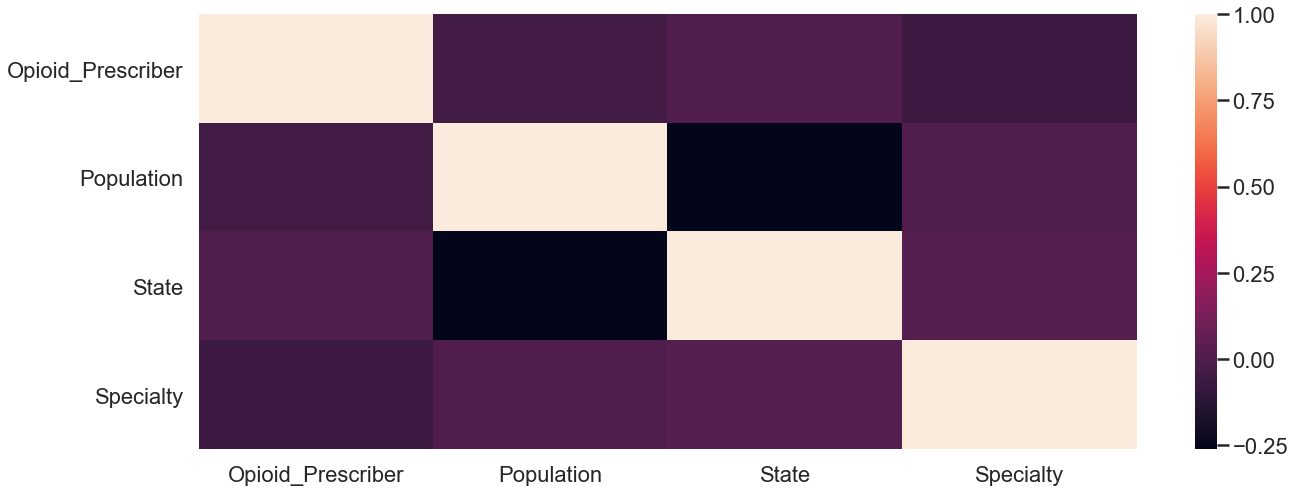

In [641]:
sns.heatmap(df1[['Opioid_Prescriber', 'Population', 'State', 'Specialty']].corr())

In [642]:
df1.corr()

,Gender,State,Specialty,Population,Opioid_Prescriber
Gender,1.000000,-0.009391,-0.144758,0.014512,0.067798
State,-0.009391,1.000000,0.015114,-0.262505,0.000096
Specialty,-0.144758,0.015114,1.000000,0.000354,-0.062143
Population,0.014512,-0.262505,0.000354,1.000000,-0.038426
Opioid_Prescriber,0.067798,0.000096,-0.062143,-0.038426,1.000000


## 3a. Ordinary Least Squares Regression Analysis

In [543]:
df = prescriber[['Gender', 'Abbrev', 'Specialty', 'Population', 'SumOpi', 'NonOpi]]

In [652]:
df

,Gender,State,Specialty,Population,SumOpi,NonOpi
0,1,42,18,26448193,17,12
1,1,42,65,26448193,0,144
2,1,42,28,26448193,17,0
3,0,42,35,26448193,155,579
4,1,42,106,26448193,132,1090
...,...,...,...,...,...,...
24754,1,40,65,844877,0,223
24755,0,40,62,844877,0,1322
24756,1,40,79,844877,66,1125
24757,0,40,79,844877,0,24


In [546]:
df.rename(columns={'Abbrev': 'State'}, inplace=True)

In [605]:
prescriber.rename(columns={'Opioid.Prescriber': 'Opioid_Prescriber'}, inplace=True)

We will pre-process the categorical variables by converting their values to discrete integers which makes it easier to handle for modeling algorithms. This is done using the LabelEncoder function of the sklearn machine learning library in Python.

In [547]:
rich = df[df['SumOpi'] >= 1]
print('Number of Opoiods Prescribed: ', len(rich))
rich = df[df['SumOpi'] == 0]
print('Number of non-Opoiods Prescribed: ', len(rich))

Number of Opoiods Prescribed:  14538
Number of non-Opoiods Prescribed:  10221


In [644]:
data = df1

m_1 = ols('Opioid_Prescriber ~ C(Gender) + C(State) + C(Specialty)', data).fit()

model = m_1

# summarize our model
model_summary = m_1.summary()

HTML(
    (model_summary
    .as_html()
    .replace('<th>  Adj. R-squared:    </th>', '<th style="background-color:#aec7e8;"> Adj. R-squared: </th>')
    .replace('<th>coef</th>', '<th style="background-color:#ffbb78;">coef</th>')
    .replace('<th>std err</th>', '<th style="background-color:#c7e9c0;">std err</th>')
    .replace('<th>P>|t|</th>', '<th style="background-color:#bcbddc;">P>|t|</th>')
    .replace('<th>[0.025</th>    <th>0.975]</th>', '<th style="background-color:#ff9896;">[0.025</th>    <th style="background-color:#ff9896;">0.975]</th>'))
)

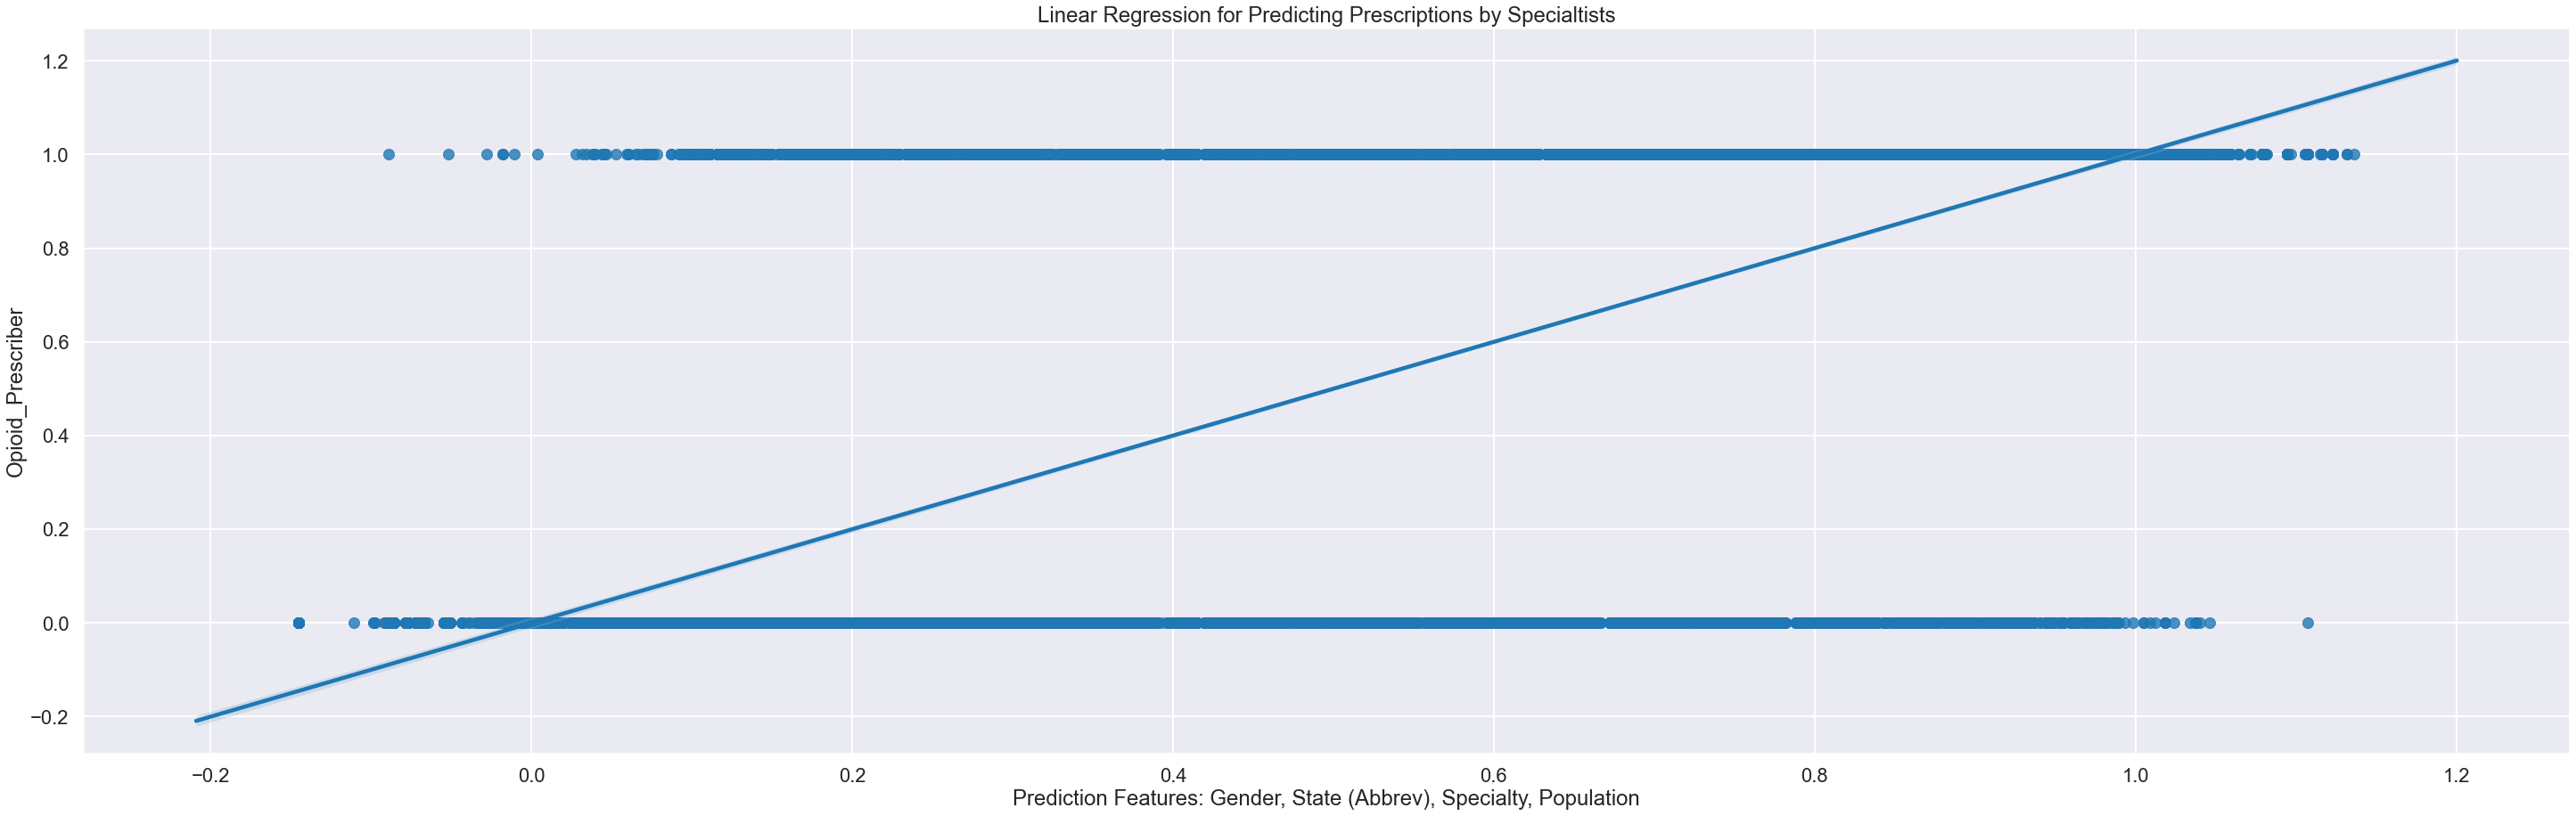

In [646]:
import random

plt.ion()

plt.figure(figsize = (50,15))
sns.regplot(x = model.fittedvalues, y = 'Opioid_Prescriber', data = data, fit_reg = True)
          
ax = plt.gca()

# recompute the ax.dataLim
ax.relim()
# update ax.viewLim using the new dataLim
ax.autoscale_view()
plt.ylabel('Opioid_Prescriber')
plt.xlabel('Prediction Features: Gender, State (Abbrev), Specialty, Population')
plt.title('Linear Regression for Predicting Prescriptions by Specialtists')
plt.draw()

In [647]:
# create a variable so we can compare our rsquared results
ols_rsq = model.rsquared
ols_rsq

0.33777870629807694

Even with all of our necessary features added, our ols model isn't very strong at r-squared: 0.41. To stregthen it we'd need to add more features and/or create a deeper dataframe with more participants.

## 3b. Random Forest Regression

In [650]:
df2_get = pd.get_dummies(prescriber, drop_first=True)
df2_get

,NPI,Gender,Abbrev,Specialty,ABILIFY,ACETAMINOPHEN.CODEINE,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,ALENDRONATE.SODIUM,...,SumOpi,TotPresc,NonOpi,Population,Region_North East,Region_South,Region_West,Spec_group_group2,Spec_group_group3,Spec_group_group4
0,1710982582,1,42,18,0,0,0,0,0,0,...,17,29,12,26448193,0,1,0,0,0,0
1,1023260569,1,42,65,0,0,0,0,0,0,...,0,144,144,26448193,0,1,0,0,0,0
2,1659334472,1,42,28,0,0,0,0,0,0,...,17,17,0,26448193,0,1,0,0,0,0
3,1952598419,0,42,35,0,0,16,0,0,0,...,155,734,579,26448193,0,1,0,0,0,0
4,1043399322,1,42,106,0,23,0,0,0,0,...,132,1222,1090,26448193,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24754,1841302700,1,40,65,0,0,0,0,0,0,...,0,223,223,844877,0,0,0,0,0,0
24755,1336293323,0,40,62,20,0,0,0,0,0,...,0,1322,1322,844877,0,0,0,0,0,0
24756,1851630727,1,40,79,13,0,0,0,0,0,...,66,1191,1125,844877,0,0,0,0,0,0
24757,1447239942,0,40,79,0,0,0,0,0,0,...,0,24,24,844877,0,0,0,0,0,0


In [659]:
df5 = pd.get_dummies(df5, drop_first=True)

In [660]:
df5

,Opioid.Prescriber,Population,Gender_M,Abbrev_AL,Abbrev_AR,Abbrev_AZ,Abbrev_CA,Abbrev_CO,Abbrev_CT,Abbrev_DE,...,Specialty_Sports Medicine,Specialty_Student in an Organized Health Care Education/Training Program,Specialty_Surgery,Specialty_Surgical Oncology,Specialty_Thoracic Surgery,Specialty_Thoracic Surgery (Cardiothoracic Vascular Surgery),Specialty_Unknown Physician Specialty Code,Specialty_Unknown Supplier/Provider,Specialty_Urology,Specialty_Vascular Surgery
0,1,26448193,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,26448193,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,26448193,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,26448193,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,26448193,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24754,0,844877,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24755,0,844877,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24756,1,844877,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24757,0,844877,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [880]:
data = df5

y = data['Opioid.Prescriber']
# drop inconsequential features
X = data.drop('Opioid.Prescriber', axis=1)  # drop NonOpi as it is our prediction feature

In [665]:
from sklearn.ensemble import RandomForestRegressor

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=23)  # 70% training and 30% test

# create regressor object
rf = RandomForestRegressor(n_estimators=100, random_state=23)

# fit the regressor with x and y data
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

rf_rsq = rf.score(X_test, y_test)

print('Model R-squared:', round(rf_rsq, 3))

Model R-squared: 0.273


In [666]:
rf_feat_df = pd.DataFrame({'feature': X.columns, 'importance': rf.feature_importances_}
             ).sort_values('importance', ascending=False)
rf_feat_df['rank'] = range(1,len(rf_feat_df)+1)
rf_feat_df.head(10)

,feature,importance,rank
74,Specialty_Family Practice,0.106276,1
0,Population,0.070633,2
71,Specialty_Emergency Medicine,0.066525,3
91,Specialty_Internal Medicine,0.063420,4
119,Specialty_Orthopedic Surgery,0.048439,5
115,Specialty_Optometry,0.045197,6
1,Gender_M,0.033824,7
78,Specialty_General Surgery,0.031941,8
135,Specialty_Psychiatry,0.029014,9
129,Specialty_Physician Assistant,0.027755,10


Our Random Forest model produces a lesser accuracy than our OLS model with a R-squared: 0.273. We are also able to check feature importance with a model from the random forest model. In regards to Specialists we can see that Family Practice, Emergency Medicine, Internal Medicine and Orthopedic Surgery specialists are the highest. Population is also a fact as well Male specialists.

In [667]:
#Create a random forest Classifier
clf = RandomForestClassifier(n_estimators=100, class_weight='balanced_subsample')

# Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

In [668]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7423263327948304


In [669]:
ypred = clf.predict(X_test)
print(classification_report(y_test, ypred))

              precision    recall  f1-score   support

           0       0.68      0.70      0.69      3084
           1       0.79      0.77      0.78      4344

    accuracy                           0.74      7428
   macro avg       0.73      0.74      0.74      7428
weighted avg       0.74      0.74      0.74      7428



In [670]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, ypred)

In [671]:
auc = roc_auc_score(y_test, ypred)
print('AUC: %.3f' % auc)

AUC: 0.737


No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.809


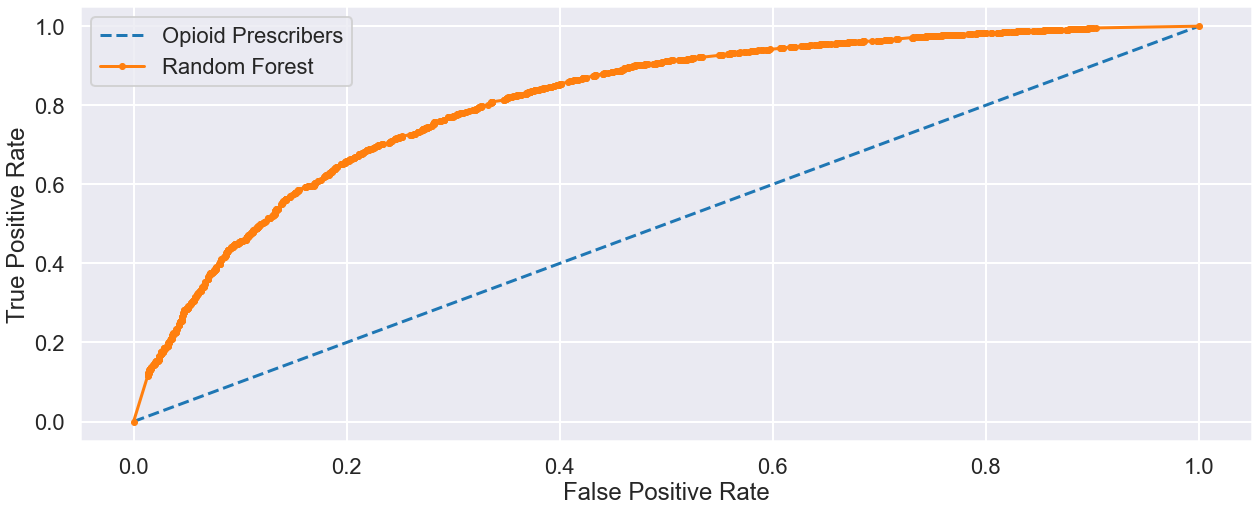

In [672]:
# generate a no ticket prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

# predict probabilities
lr_probs = clf.predict_proba(X_test)
# keep probabilities for the positive outcome (ticket) only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Opioid Prescribers')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Random Forest')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

## 3c. XGBoost

In [882]:
import xgboost

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=23)

model = xgboost.XGBRegressor(objective ='reg:squarederror', max_depth = 3, learning_rate = 0.05) 
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.05, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

In [883]:
model.predict(X_test)

xgb_rsq = model.score(X_test, y_test)
xgb_rsq

0.24726507023740574

In [884]:
model.score(X_train, y_train)

0.2538868102131904

With a test score of 0.247 and a training score of .253 our model isn't too overfit.

In [570]:
#for tuning parameters
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [625]:
parameters_for_testing = {
    'min_child_weight':[1,2,3],
    'learning_rate':[0.1,0.07,0.05],
    'max_depth':[3,5],
}

                    
xgb_model = xgboost.XGBRegressor(objective = 'reg:squarederror', learning_rate =0.1, n_estimators=1000, max_depth=5,
     min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, nthread=6, scale_pos_weight=1, seed=15)

gsearch1 = GridSearchCV(cv = 5, estimator = xgb_model, param_grid = parameters_for_testing, 
                        n_jobs=6,iid=False, verbose=10,scoring='r2')
gsearch1.fit(X_train,y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed: 10.7min
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed: 10.7min
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed: 30.4min
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed: 46.3min
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed: 644.0min
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed: 656.8min
[Parallel(n_jobs=6)]: Done  49 tasks      | elapsed: 683.2min
[Parallel(n_jobs=6)]: Done  60 tasks      | elapsed: 709.3min
[Parallel(n_jobs=6)]: Done  73 tasks      | elapsed: 737.6min
[Parallel(n_jobs=6)]: Done  90 out of  90 | elapsed: 845.4min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.8,
                                    gamma=0, gpu_id=None,
                                    importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=0.1, max_delta_step=None,
                                    max_depth=5, min_child_weight=1,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=1000, n...
                                    objective='reg:squarederror',
                                    random_state=None, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=1,
                                    seed=15, subsample=0.8, tree_method=None,
   

In [676]:
print('best params')
print (gsearch1.best_params_)
print('best score')
print (gsearch1.best_score_)

best params
{'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 3}
best score
0.7737437425821624


In [678]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=23)

model = xgboost.XGBRegressor(objective='reg:squarederror',
                             max_depth=5, learning_rate=0.05, min_child_weight=2)

model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.05, max_delta_step=0, max_depth=5,
             min_child_weight=2, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

In [679]:
xgb_feature_importances = pd.DataFrame({'feature': X.columns,
                                        'importance': model.feature_importances_}).sort_values('importance',
                                                                                               ascending=False)
xgb_feature_importances.head(10)

,feature,importance
74,Specialty_Family Practice,0.116287
71,Specialty_Emergency Medicine,0.083808
91,Specialty_Internal Medicine,0.081511
119,Specialty_Orthopedic Surgery,0.063751
115,Specialty_Optometry,0.054791
135,Specialty_Psychiatry,0.049357
78,Specialty_General Surgery,0.044711
114,Specialty_Ophthalmology,0.039867
68,Specialty_Dentist,0.034748
57,Specialty_Cardiology,0.031903


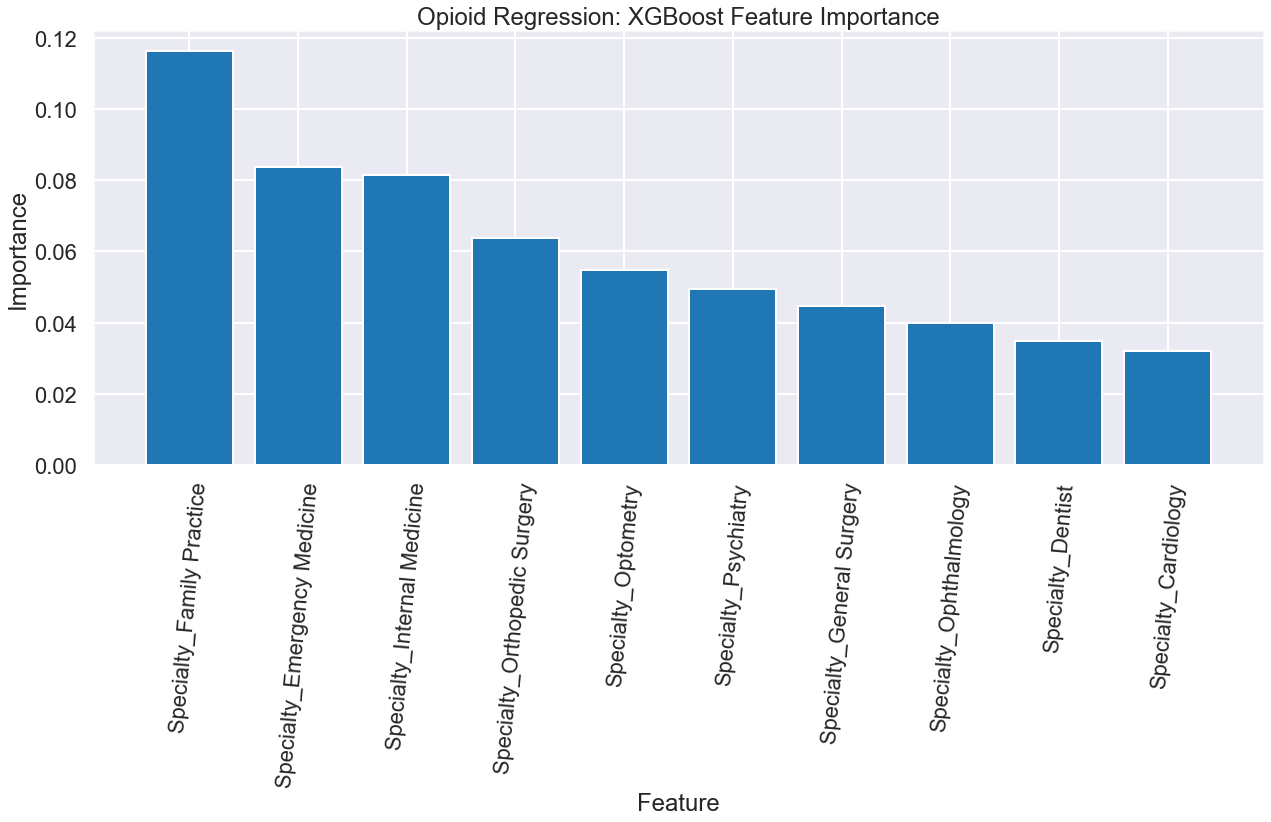

In [680]:
plt.bar(xgb_feature_importances.feature[:10], xgb_feature_importances.importance[:10])
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(xgb_feature_importances.feature[:10], rotation = 90)
plt.title('Opioid Regression: XGBoost Feature Importance')
plt.xticks(rotation=85)
plt.show()

In [886]:
model.predict(X_test)

xgb_rsq = model.score(X_test, y_test)
xgb_rsq

0.24726507023740574

XGBoost score is low as well. Just like with Random Forest we can see that Internal Medicine and Family Practice are among the highest in regards to Specialists. None of the states appear in the Top 10 of importance in this model.

## 3d. Ridge and Lasso Regression

In [571]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn import linear_model


In [705]:
from sklearn.datasets import make_regression
X_all, y_all = sklearn.datasets.make_regression(n_samples=100, n_features=50, n_informative=10)

In [891]:
data = df5

ys = data['Opioid.Prescriber'].values.reshape(-1,1)
# drop inconsequential features
Xs = data.drop('Opioid.Prescriber', axis=1)  # drop NonOpi as it is our prediction feature

In [892]:
lin_reg = LinearRegression()

MSEs = cross_val_score(lin_reg, Xs, ys, scoring='neg_mean_squared_error', cv=5)

mean_MSE = np.mean(MSEs)

print(mean_MSE)

-0.16613872877811203


In [894]:
alpha = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20]

ridge = Ridge()
parameters = {'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20]}
ridge_regressor = GridSearchCV(ridge, parameters,scoring='neg_mean_squared_error', cv=5)

ridge_regressor.fit(Xs, ys)

GridSearchCV(cv=5, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [1e-15, 1e-10, 1e-08, 0.0001, 0.001, 0.01, 1,
                                   5, 10, 20]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [895]:
ridge_regressor.best_params_

{'alpha': 5}

In [896]:
ridge_regressor.best_score_

-0.16457370214805916

In [897]:
lasso = Lasso()
parameters = {'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20]}
lasso_regressor = GridSearchCV(lasso, parameters, scoring='neg_mean_squared_error', cv = 5)

lasso_regressor.fit(Xs, ys)

GridSearchCV(cv=5, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [1e-15, 1e-10, 1e-08, 0.0001, 0.001, 0.01, 1,
                                   5, 10, 20]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [898]:
lasso_regressor.best_params_

{'alpha': 0.0001}

In [899]:
lasso_regressor.best_score_

-0.1652541131002687

In [992]:
model = linear_model.LinearRegression()

In [993]:
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [994]:
#Define sum of squared errors between model and data
def sse(resid):
    return np.sum(resid**2)

In [995]:
resid_train = y_train - model.predict(X_train)
sse_train = sse(resid_train)
sse_train

2770.796437879273

In [996]:
resid_test = y_test - model.predict(X_test)
sse_test = sse(resid_test)
sse_test

1215.7610706311361

In [997]:
model.score(X_train, y_train)

0.3399635543912346

In [998]:
model.score(X_test, y_test)

0.3259130150261611

In [999]:
lin_rsq = model.score(X_test, y_test)
lin_rsq

0.3259130150261611

The big difference between the scores for the training and testing datasets show that the model is overfitted.

In [689]:
#Define plot_residuals_and_coeff(resid_train, resid_test, coeff)
def plot_residuals_and_coeff(resid_train, resid_test, coeff):
    fig, axes = plt.subplots(1, 3, figsize=(25,13))
    axes[0].bar(np.arange(len(resid_train)), resid_train, color='red')
    axes[0].set_xlabel('Sample Number')
    axes[0].set_ylabel('Residual')
    axes[0].set_title('Training Data')
    axes[1].bar(np.arange(len(resid_test)), resid_test)
    axes[1].set_xlabel('Sample Number')
    axes[1].set_ylabel('Residual')
    axes[1].set_title('Test Data')
    axes[2].bar(np.arange(len(coeff)), coeff)
    axes[2].set_xlabel('Coefficient Number')
    axes[2].set_ylabel('Coefficient')
    fig.tight_layout()
    return fig, axes

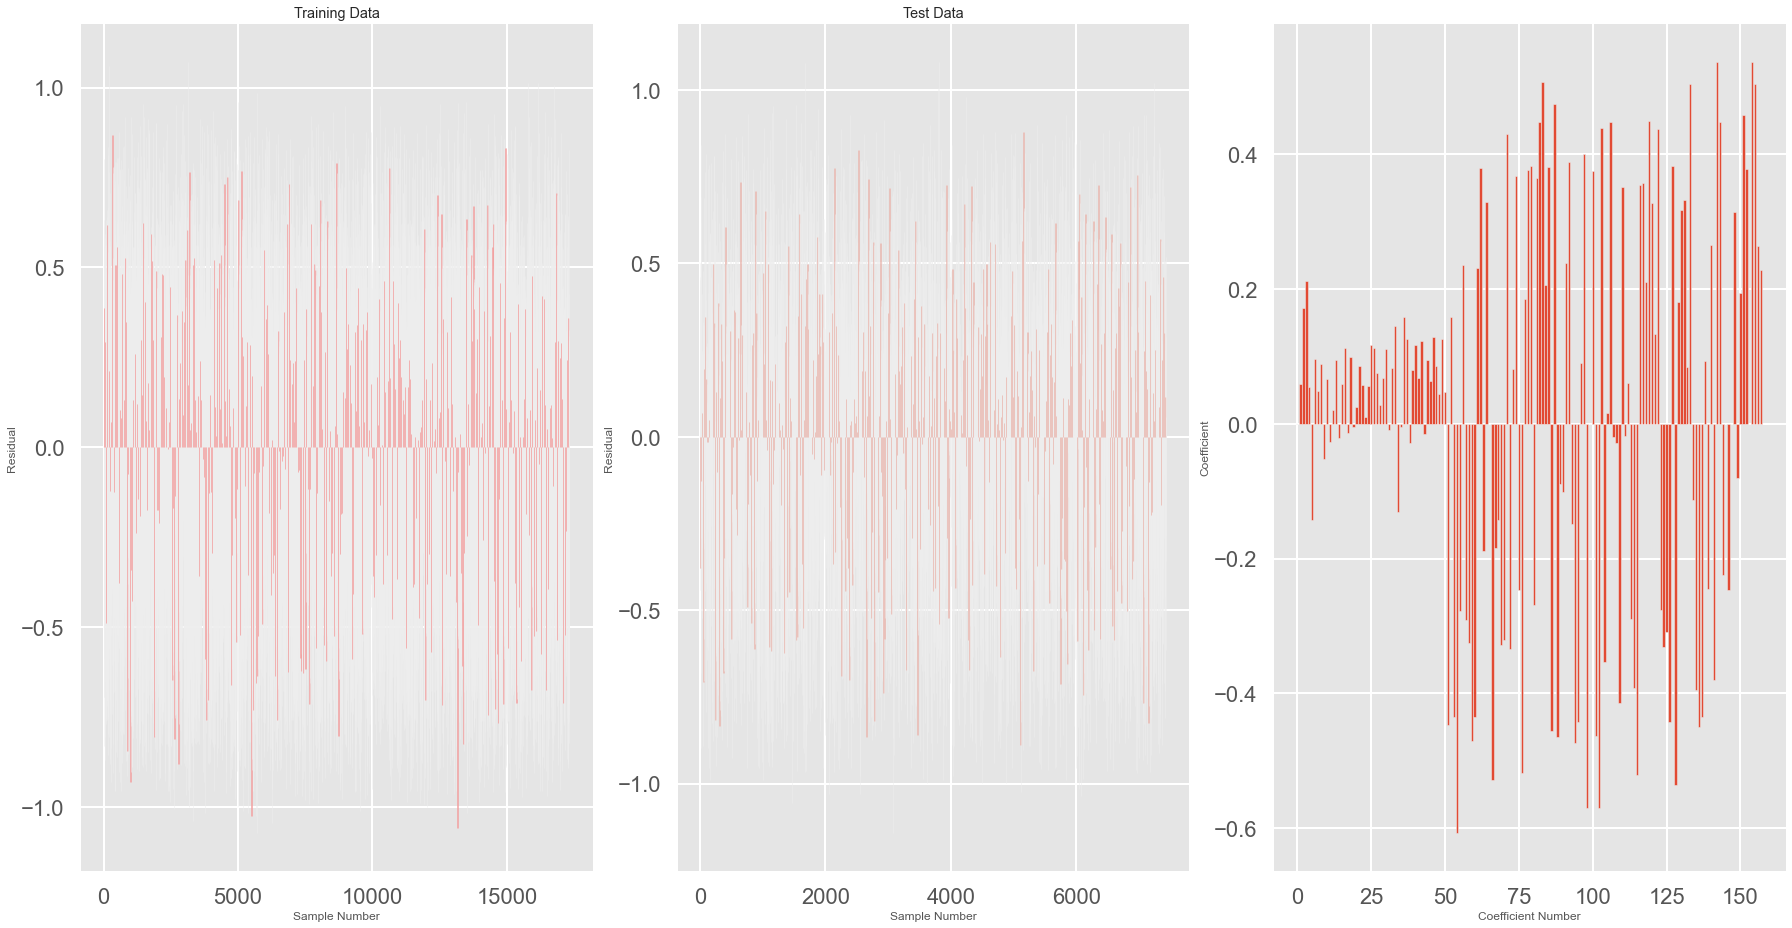

In [947]:
fig, ax = plot_residuals_and_coeff(resid_train, resid_test, model.coef_)

The residual between the ordinary linear regression model and the training data, the model and the test data, the values of the coefficients for the 50 features.

In [1000]:
#build Ridge model
model = linear_model.Ridge(alpha=2.5)

In [1001]:
model.fit(X_train, y_train)

Ridge(alpha=2.5, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [1002]:
resid_train = y_train - model.predict(X_train)
sse_train = sse(resid_train)
sse_train

2775.361096121753

In [1003]:
resid_test = y_test- model.predict(X_test)
sse_test = sse(resid_test)
sse_test

1212.9682711960158

In [1004]:
rid_rsq = model.score(X_test, y_test)
rid_rsq

0.32746150164605226

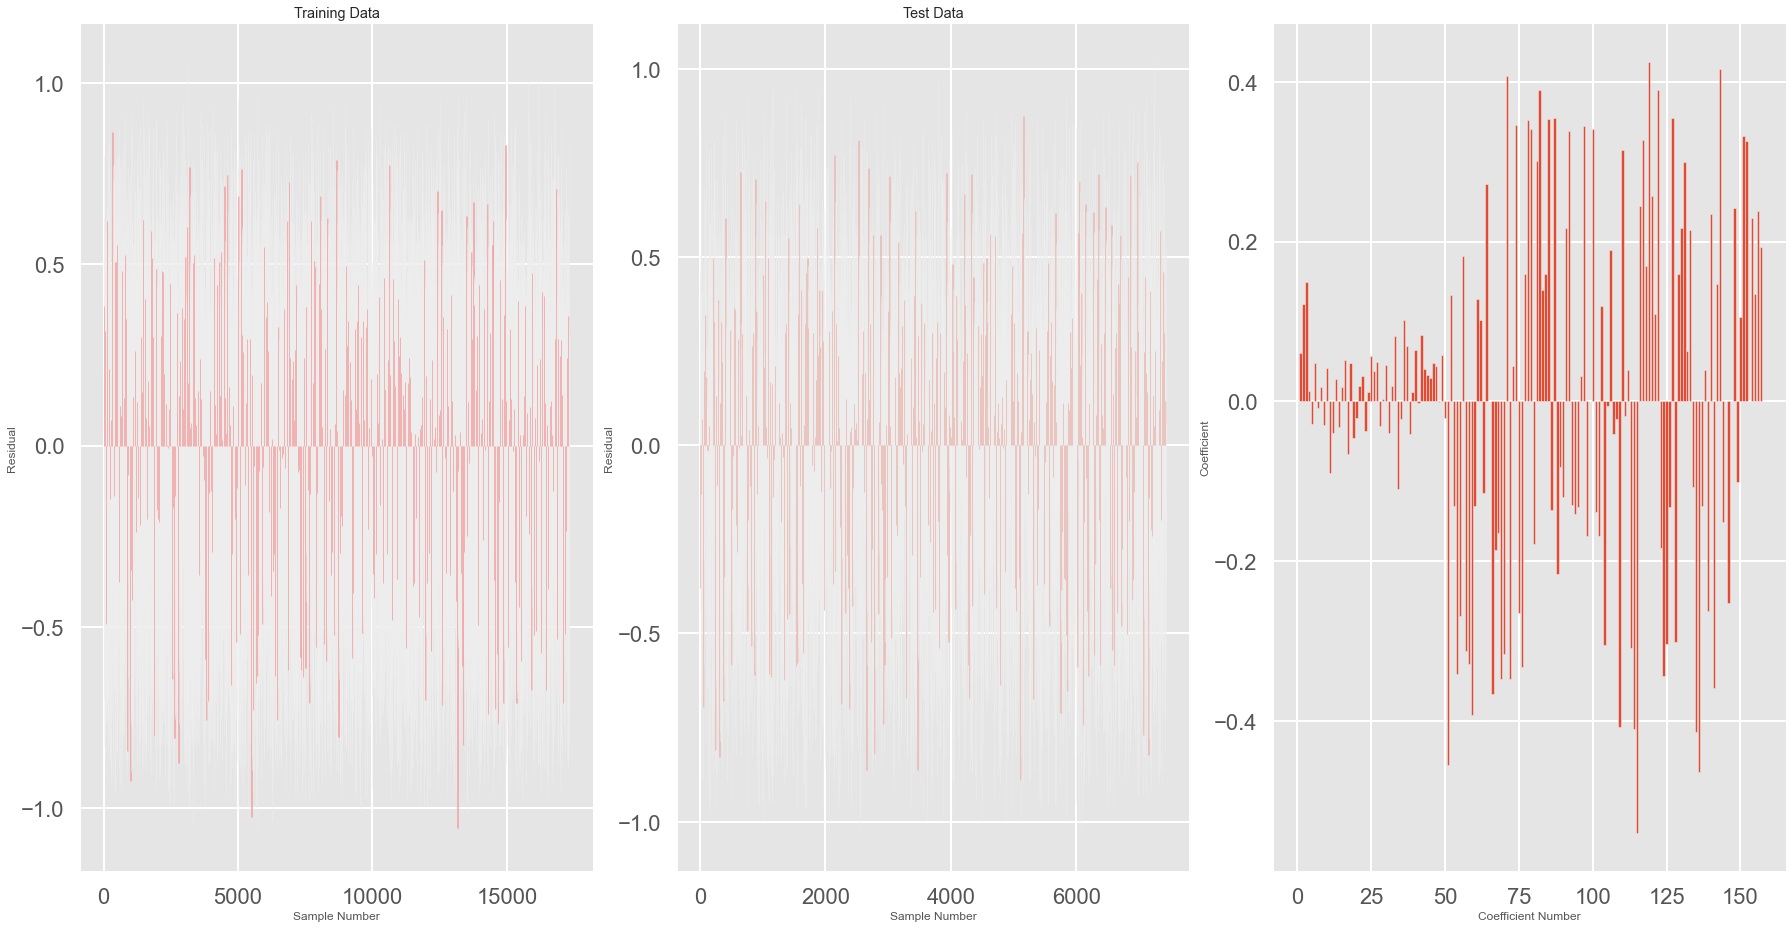

In [961]:
fig, ax = plot_residuals_and_coeff(resid_train, resid_test, model.coef_)

In [1005]:
#build Lasso model
model = linear_model.Lasso(alpha=1.0)
model.fit(X_train, y_train)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [1006]:
resid_train = y_train - model.predict(X_train)
sse_train = sse(resid_train)
sse_train

4192.153259497924

In [1007]:
resid_test = y_test - model.predict(X_test)
sse_test = sse(resid_test)
sse_test

1800.600022525502

In [1008]:
model.score(X_test, y_test)

0.001645085001821811

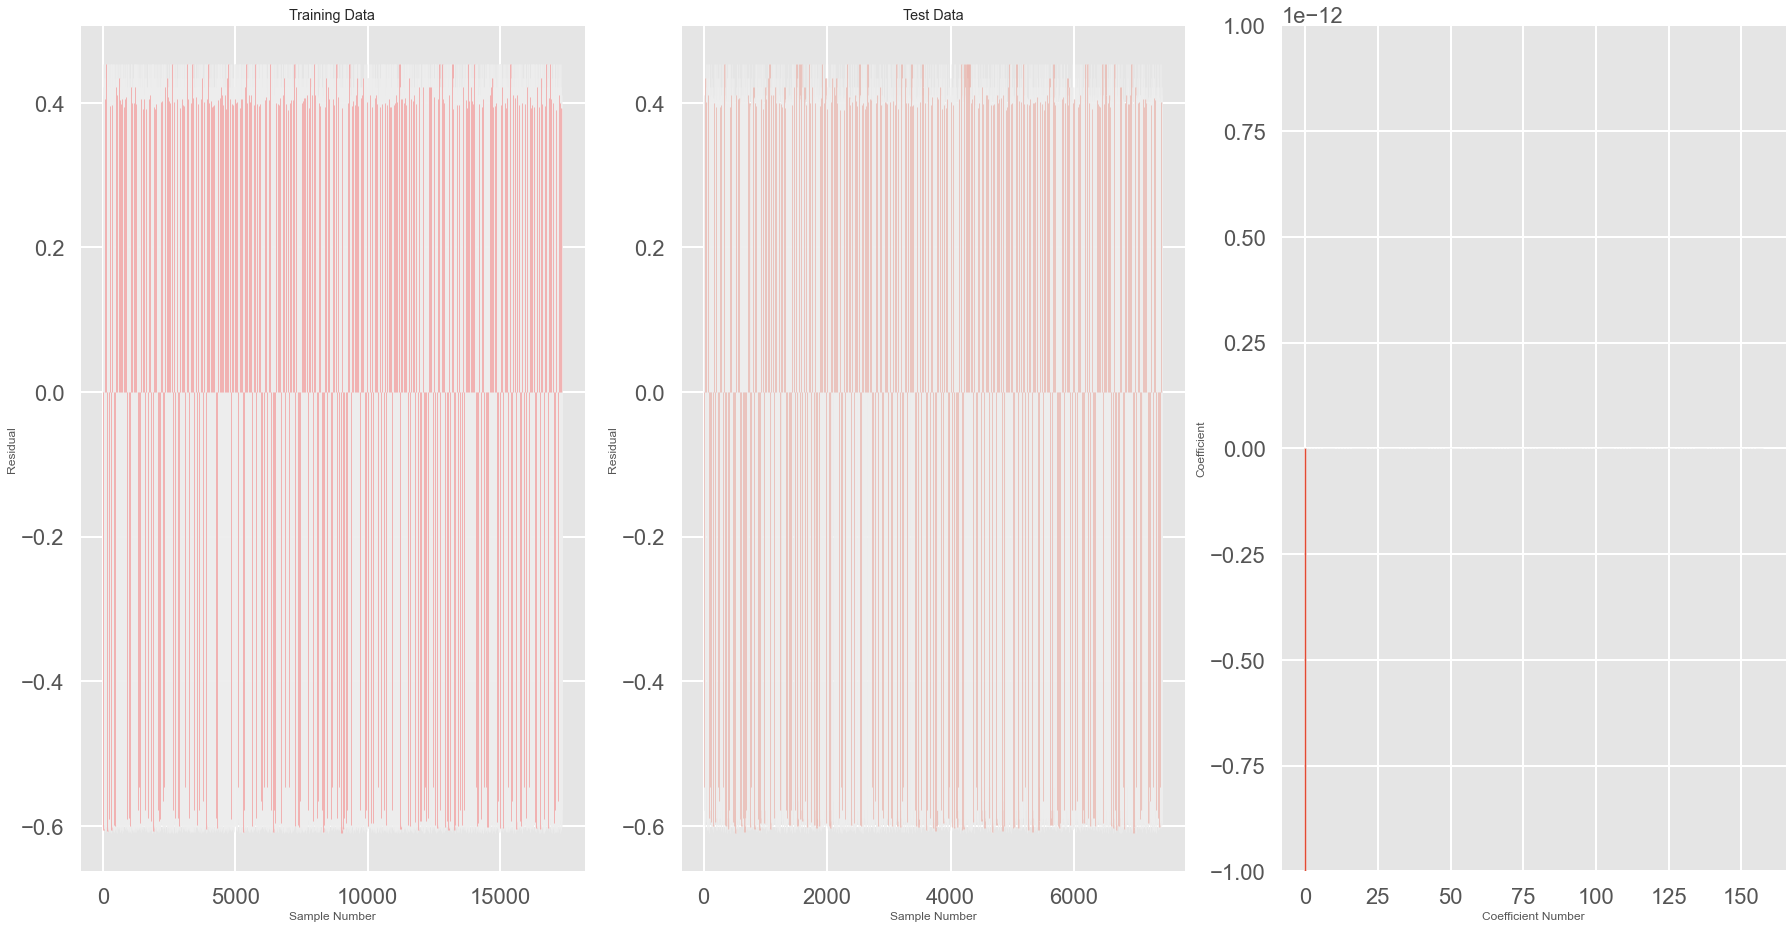

In [967]:
fig, ax = plot_residuals_and_coeff(resid_train, resid_test, model.coef_)

In [1009]:
las_rsq = model.score(X_test, y_test)
las_rsq

0.001645085001821811

In [969]:
#Create arrays
alphas = np.logspace(-4, 2, 100)
coeffs = np.zeros((len(alphas), X_train.shape[1]))
sse_train = np.zeros_like(alphas)
sse_test = np.zeros_like(alphas)

In [970]:
#Loop through the a values and perform Lasso regression
for n, alpha in enumerate(alphas):
    model = linear_model.Lasso(alpha=alpha)
    model.fit(X_train, y_train)
    coeffs[n,:] = model.coef_
    sse_train[n] = sse(y_train - model.predict(X_train))
    sse_test[n] = sse(y_test - model.predict(X_test))

Text(0, 0.5, 'sse')

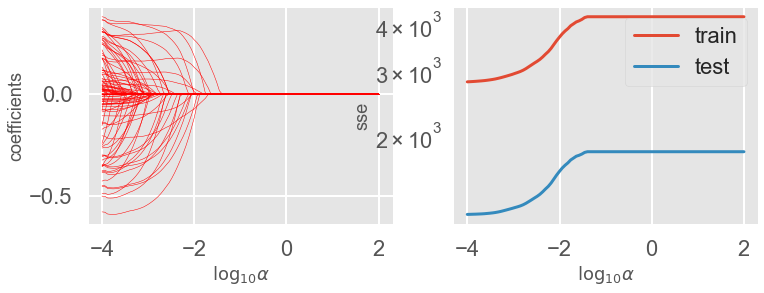

In [971]:
#Plot coefficientsw and SSEs for the training and testing. Left panel is large number coefficients are nonzero
fig, axes = plt.subplots(1, 2, figsize=(12,4), sharex=True)
for n in range(coeffs.shape[1]):
    axes[0].plot(np.log10(alphas), coeffs[:, n], color='r', lw=0.5)
    
axes[1].semilogy(np.log10(alphas), sse_train, label='train')
axes[1].semilogy(np.log10(alphas), sse_test, label='test')
axes[1].legend(loc=0)
axes[0].set_xlabel(r'${\log_{10}}\alpha$', fontsize=18)
axes[0].set_ylabel(r'coefficients', fontsize=18)
axes[1].set_xlabel(r'${\log_{10}}\alpha$', fontsize=18)
axes[1].set_ylabel(r'sse', fontsize=18)

The coefficients and the sum of squared errors (SSEs) for the training and testing datasets for Lasso regression as a function of the logarithm of the regularization strength parameter a

In [1010]:
model = linear_model.ElasticNetCV()

In [1011]:
model.fit(X_train, y_train)

ElasticNetCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
             l1_ratio=0.5, max_iter=1000, n_alphas=100, n_jobs=None,
             normalize=False, positive=False, precompute='auto',
             random_state=None, selection='cyclic', tol=0.0001, verbose=0)

In [1012]:
model.alpha_

395.70628205076986

In [1013]:
model.l1_ratio

0.5

In [1014]:
resid_train = y_train - model.predict(X_train)
sse_train = sse(resid_train)
sse_train

4192.153265289125

In [1015]:
resid_test = y_test - model.predict(X_test)
sse_test = sse(resid_test)
sse_test

1800.6006698615347

In [1016]:
model.score(X_test, y_test)

0.001644726081960757

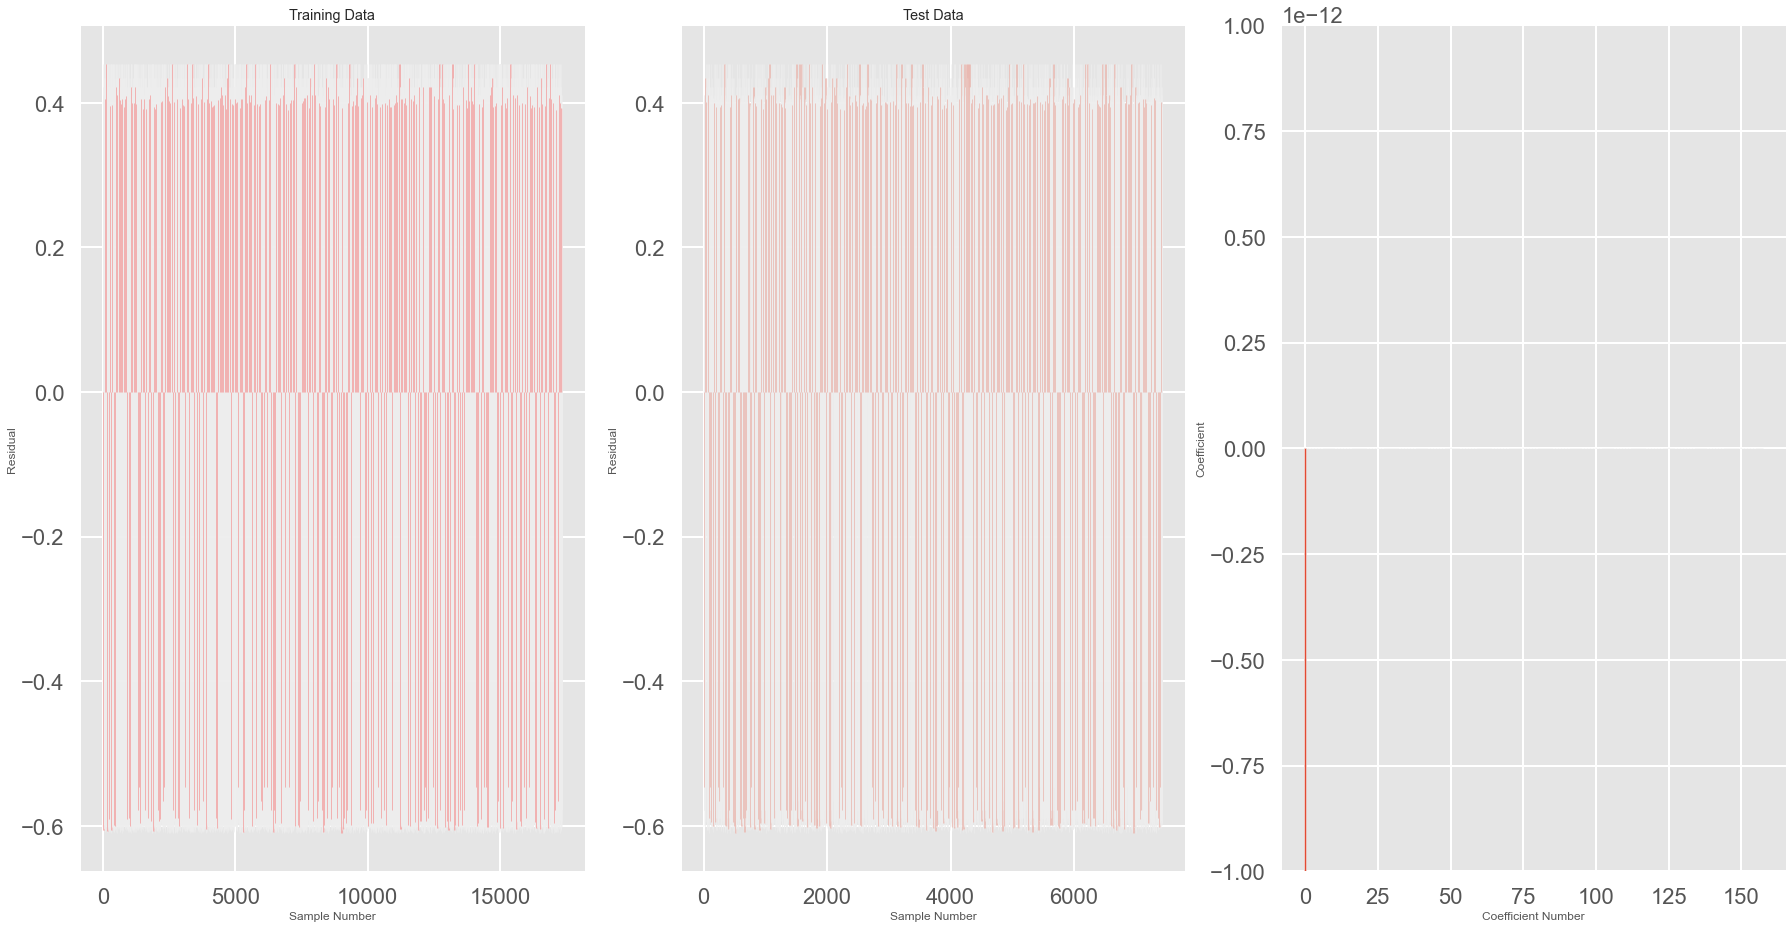

In [1021]:
fig, ax = plot_residuals_and_coeff(resid_train, resid_test, model.coef_)

In [1017]:
ela_rsq = model.score(X_test, y_test)
ela_rsq

0.001644726081960757

training score: 0.0013795676148582459
test score:  0.001645085001821811
number of features used:  1
training score for alpha=0.01: 0.120829512815265
test score for alpha =0.01:  0.11701618597179997
number of features used: for alpha =0.01: 9
training score for alpha=0.0001: 0.33567482501633106
test score for alpha =0.0001:  0.32581576633729326
number of features used: for alpha =0.0001: 107
LR training score: 0.3399635543912346
LR test score:  0.3259130150261611


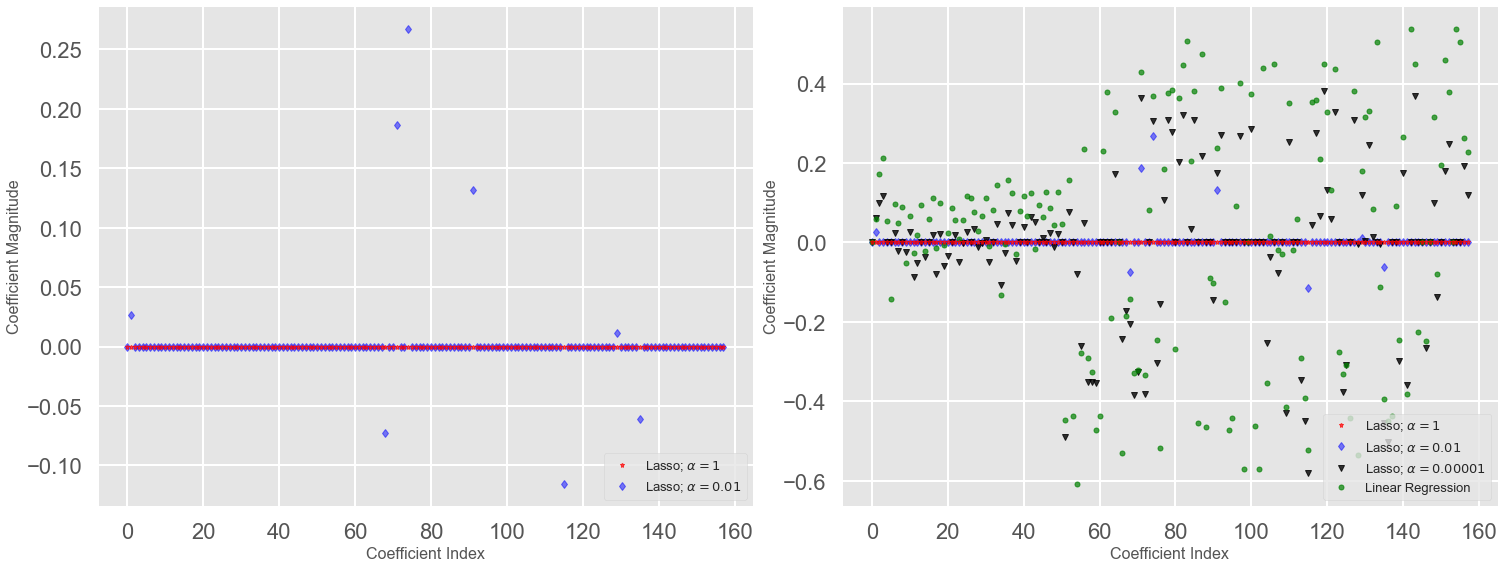

In [972]:
#X_train,X_test,y_train,y_test=train_test_split(X,Y, test_size=0.3, random_state=31)
#lasso = Lasso()
lasso.fit(X_train,y_train)
train_score=lasso.score(X_train,y_train)
test_score=lasso.score(X_test,y_test)
coeff_used = np.sum(lasso.coef_!=0)
print ("training score:", train_score) 
print ("test score: ", test_score)
print ("number of features used: ", coeff_used)

lasso001 = Lasso(alpha=0.01, max_iter=10e5)
lasso001.fit(X_train,y_train)
train_score001=lasso001.score(X_train,y_train)
test_score001=lasso001.score(X_test,y_test)
coeff_used001 = np.sum(lasso001.coef_!=0)
print ("training score for alpha=0.01:", train_score001) 
print ("test score for alpha =0.01: ", test_score001)
print ("number of features used: for alpha =0.01:", coeff_used001)

lasso00001 = Lasso(alpha=0.0001, max_iter=10e5)
lasso00001.fit(X_train,y_train)
train_score00001=lasso00001.score(X_train,y_train)
test_score00001=lasso00001.score(X_test,y_test)
coeff_used00001 = np.sum(lasso00001.coef_!=0)

print ("training score for alpha=0.0001:", train_score00001)
print ("test score for alpha =0.0001: ", test_score00001)
print ("number of features used: for alpha =0.0001:", coeff_used00001)

lr = LinearRegression()
lr.fit(X_train,y_train)
lr_train_score=lr.score(X_train,y_train)
lr_test_score=lr.score(X_test,y_test)
print ("LR training score:", lr_train_score)
print ("LR test score: ", lr_test_score)

plt.subplot(1,2,1)
plt.plot(lasso.coef_,alpha=0.7,linestyle='none',marker='*',markersize=5,color='red',label=r'Lasso; $\alpha = 1$',zorder=7) # alpha here is for transparency
plt.plot(lasso001.coef_,alpha=0.5,linestyle='none',marker='d',markersize=6,color='blue',label=r'Lasso; $\alpha = 0.01$') # alpha here is for transparency

plt.xlabel('Coefficient Index',fontsize=16)
plt.ylabel('Coefficient Magnitude',fontsize=16)
plt.legend(fontsize=13,loc=4)
plt.subplot(1,2,2)
plt.plot(lasso.coef_,alpha=0.7,linestyle='none',marker='*',markersize=5,color='red',label=r'Lasso; $\alpha = 1$',zorder=7) # alpha here is for transparency
plt.plot(lasso001.coef_,alpha=0.5,linestyle='none',marker='d',markersize=6,color='blue',label=r'Lasso; $\alpha = 0.01$') # alpha here is for transparency
plt.plot(lasso00001.coef_,alpha=0.8,linestyle='none',marker='v',markersize=6,color='black',label=r'Lasso; $\alpha = 0.00001$') # alpha here is for transparency
plt.plot(lr.coef_,alpha=0.7,linestyle='none',marker='o',markersize=5,color='green',label='Linear Regression',zorder=2)
plt.xlabel('Coefficient Index',fontsize=16)
plt.ylabel('Coefficient Magnitude',fontsize=16)
plt.legend(fontsize=13,loc=4)
plt.tight_layout()
plt.show()


In [982]:
# Generate Prediction on test set 
lreg_y_pred = lreg.predict(X_test)  
  
# calculating Mean Squared Error (mse) 
mean_squared_error = np.mean((lreg_y_pred - y_test)**2) 
print("Mean squared Error on test set : ", mean_squared_error) 
  
# Putting together the coefficient and their corrsponding variable names  
lreg_coefficient = pd.DataFrame() 
lreg_coefficient["Columns"] = X_train.columns 
lreg_coefficient['Coefficient Estimate'] = pd.Series(lreg.coef_) 
print(lreg_coefficient) 

Mean squared Error on test set :  0.162026609131981
                                               Columns  Coefficient Estimate
0                                           Population          5.410618e-09
1                                             Gender_M          5.319907e-02
2                                            Abbrev_AL          1.987363e-01
3                                            Abbrev_AR          1.902163e-01
4                                            Abbrev_AZ          8.460892e-02
..                                                 ...                   ...
153  Specialty_Thoracic Surgery (Cardiothoracic Vas...          3.607150e-09
154         Specialty_Unknown Physician Specialty Code          9.866717e-02
155                Specialty_Unknown Supplier/Provider         -6.700530e-03
156                                  Specialty_Urology         -2.185219e-01
157                         Specialty_Vascular Surgery         -1.945577e-01

[158 rows x 2 columns]


In [983]:
# Train the model  
ridgeR = Ridge(alpha = 1) 
ridgeR.fit(X_train, y_train) 
y_pred = ridgeR.predict(X_test) 
  
# calculate mean square error 
mean_squared_error_ridge = np.mean((y_pred - y_test)**2) 
print(mean_squared_error_ridge) 
  
# get ridge coefficient and print them 
ridge_coefficient = pd.DataFrame() 
ridge_coefficient["Columns"]= X_train.columns 
ridge_coefficient['Coefficient Estimate'] = pd.Series(ridgeR.coef_) 
print(ridge_coefficient)

0.16337133815195665
                                               Columns  Coefficient Estimate
0                                           Population          1.855964e-09
1                                             Gender_M          5.981254e-02
2                                            Abbrev_AL          1.370314e-01
3                                            Abbrev_AR          1.684983e-01
4                                            Abbrev_AZ          2.560006e-02
..                                                 ...                   ...
153  Specialty_Thoracic Surgery (Cardiothoracic Vas...          0.000000e+00
154         Specialty_Unknown Physician Specialty Code          3.490415e-01
155                Specialty_Unknown Supplier/Provider          2.421541e-01
156                                  Specialty_Urology          2.484312e-01
157                         Specialty_Vascular Surgery          2.087089e-01

[158 rows x 2 columns]


In [984]:
# Train the model 
lasso = Lasso(alpha = 1) 
lasso.fit(X_train, y_train) 
y_pred1 = lasso.predict(X_test) 
  
# Calculate Mean Squared Error 
mean_squared_error = np.mean((y_pred1 - y_test)**2) 
print("Mean squared error on test set", mean_squared_error) 
lasso_coeff = pd.DataFrame() 
lasso_coeff["Columns"] = x_train.columns 
lasso_coeff['Coefficient Estimate'] = pd.Series(lasso.coef_) 
  
print(lasso_coeff) 

Mean squared error on test set 0.24240711127160805
                                               Columns  Coefficient Estimate
0                                           Population         -1.688927e-09
1                                             Gender_M          0.000000e+00
2                                            Abbrev_AL          0.000000e+00
3                                            Abbrev_AR          0.000000e+00
4                                            Abbrev_AZ          0.000000e+00
..                                                 ...                   ...
153  Specialty_Thoracic Surgery (Cardiothoracic Vas...          0.000000e+00
154         Specialty_Unknown Physician Specialty Code          0.000000e+00
155                Specialty_Unknown Supplier/Provider          0.000000e+00
156                                  Specialty_Urology          0.000000e+00
157                         Specialty_Vascular Surgery          0.000000e+00

[158 rows x 2 columns]


In [985]:
# Train the model 
e_net = ElasticNet(alpha = 1) 
e_net.fit(X_train, y_train) 
  
# calculate the prediction and mean square error 
y_pred_elastic = e_net.predict(X_test) 
mean_squared_error = np.mean((y_pred_elastic - y_test)**2) 
print("Mean Squared Error on test set", mean_squared_error) 
  
e_net_coeff = pd.DataFrame() 
e_net_coeff["Columns"] = X_train.columns 
e_net_coeff['Coefficient Estimate'] = pd.Series(e_net.coef_) 
e_net_coeff 

Mean Squared Error on test set 0.24240711105107615


,Columns,Coefficient Estimate
0,Population,-1.688931e-09
1,Gender_M,0.000000e+00
2,Abbrev_AL,0.000000e+00
3,Abbrev_AR,0.000000e+00
4,Abbrev_AZ,0.000000e+00
...,...,...
153,Specialty_Thoracic Surgery (Cardiothoracic Vas...,0.000000e+00
154,Specialty_Unknown Physician Specialty Code,0.000000e+00
155,Specialty_Unknown Supplier/Provider,0.000000e+00
156,Specialty_Urology,0.000000e+00


In [1020]:
reg_model = pd.DataFrame({'name':['Linear Reg','Ridge','Lasso', 'ElasticNet'],
                                 'R-squared':[lin_rsq,rid_rsq, las_rsq, ela_rsq]})
reg_model

,name,R-squared
0,Linear Reg,0.325913
1,Ridge,0.327462
2,Lasso,0.001645
3,ElasticNet,0.001645


Linear regression model

## 4. Comparing Models

In [887]:
regressor_models2 = pd.DataFrame({'name':['OLS Regression','Random Forest','XGBoost', 'Lasso'],
                                 'R-squared':[ols_rsq,rf_rsq, xgb_rsq, las_rsq, ela_rsq]})
regressor_models2

,name,R-squared
0,OLS Regression,0.337779
1,Random Forest,0.272954
2,XGBoost,0.247265
3,Lasso,0.001645


None of our models were especially impressive. XGBoost is our highest but overall, our models don't really give us an impressive score. To better the score we'd need to add more features. These models tried to predict if a specialist would prescribe an opioid to their patients. We certainly saw some of the variables that seems to saw a strong connection to opioid prescriptions. in regards to specialists, the type of specialists who had the highest scores were based around environments in which their patients would be in some sort of physical pain.

## 5. Clustering

In [142]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.cluster import AffinityPropagation
from sklearn import metrics

import matplotlib.cm as cm

In [164]:
#using our original dataset we'll seperate it as part of some data wrangling to better use
df_new = prescriber[['NPI', 'Specialty', 'Spec_group']]
df_call = prescriber[['NPI', 'Abbrev', 'Region', 'Opioid.Prescriber', 'Population', 'Gender', 'SumOpi']]

In [167]:
df_new['N'] = 1

C:\Users\Jimsyd\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [168]:
df_merge = pd.merge(df_new, df_call, how='left', on='NPI')

### 5a. Clustering with Specialty and SumOpi columns (SumOpi = total sum of opioids prescribed per specialists)

In [170]:
df_pivot = df_merge.pivot_table(index='Specialty', columns='SumOpi', values='N').fillna(0)

In [121]:
df_pivot

SumOpi,0,11,12,13,14,15,16,17,18,19,...,4283,4473,4687,4941,5021,5793,5890,6003,14674,15234
Specialty,,,,,,,,,,,,,,,,,,,,,
Addiction Medicine,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Allergy/Immunology,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Anesthesiology,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
Behavioral Analyst,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CRNA,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Thoracic Surgery (Cardiothoracic Vascular Surgery),1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Unknown Physician Specialty Code,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Unknown Supplier/Provider,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [122]:
df_merge

,NPI,Specialty,Spec_group,N,Abbrev,Region,Opioid.Prescriber,Population,Gender,SumOpi
0,1710982582,Dentist,group1,1,TX,South,1,26448193,M,17
1,1023260569,Optometry,group1,1,TX,South,0,26448193,M,0
2,1659334472,General Surgery,group1,1,TX,South,1,26448193,M,17
3,1952598419,Hematology/Oncology,group1,1,TX,South,1,26448193,F,155
4,1043399322,Urology,group1,1,TX,South,1,26448193,M,132
...,...,...,...,...,...,...,...,...,...,...
24754,1841302700,Optometry,group1,1,SD,Central,0,844877,M,0
24755,1336293323,Nurse Practitioner,group1,1,SD,Central,0,844877,F,0
24756,1851630727,Physician Assistant,group1,1,SD,Central,1,844877,M,66
24757,1447239942,Physician Assistant,group1,1,SD,Central,0,844877,F,0


#### K-Means Clustering: We want to maximize the distance between centroids and minimize the distance between data points and the respective centroid for the cluster they are in.

In [123]:
#Create a numpy matrix x_cols with only the columns representing the offers (i.e. the 0/1 colums)
x_cols = df_pivot.values
x_cols[:5,:]

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [124]:
#Write code that applies the KMeans clustering method from scikit-learn to this matrix
from sklearn.cluster import KMeans
model = KMeans(n_clusters = 5, random_state = 0)
model.fit(x_cols)

print(model.labels_)
print(model.cluster_centers_)
print(model.inertia_)

[0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 3 3 0 2 0 0 1 3 0 3 3 0 0 0 0 0 0 3 0
 0 0 0 0 4 0 0 0 0 0 0 0 0 3 0 0 0 0 3 0 3 0 0 3 0 2 3 3 0 0 3 0 2 0 3 0 0
 0 0 0 3 0 2 0 3 3 0 0 0 0 0 0 3 3 0 0 3 0 0 0 0 0 3 0 0 0 0 0 0 3 3]
[[ 9.10256410e-01  2.69230769e-01  3.07692308e-01 ...  1.28205128e-02
  -5.20417043e-18  1.28205128e-02]
 [ 1.00000000e+00  1.00000000e+00  1.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 1.00000000e+00  1.00000000e+00  1.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 1.00000000e+00  9.58333333e-01  9.16666667e-01 ...  5.20417043e-18
   4.16666667e-02  5.20417043e-18]
 [ 1.00000000e+00  1.00000000e+00  1.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]
1913.0384615384614


In [125]:
model.predict(x_cols)

array([0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 0, 2,
       0, 0, 1, 3, 0, 3, 3, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 4, 0, 0,
       0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 3, 0, 3, 0, 0, 3, 0, 2, 3, 3, 0,
       0, 3, 0, 2, 0, 3, 0, 0, 0, 0, 0, 3, 0, 2, 0, 3, 3, 0, 0, 0, 0, 0,
       0, 3, 3, 0, 0, 3, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 3, 3])

In [126]:
#Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
ks = np.arange(1,11)
SS = []

for k in ks:
    model = KMeans(n_clusters = k, random_state = 10)
    model.fit(x_cols)
    SS.append(model.inertia_)

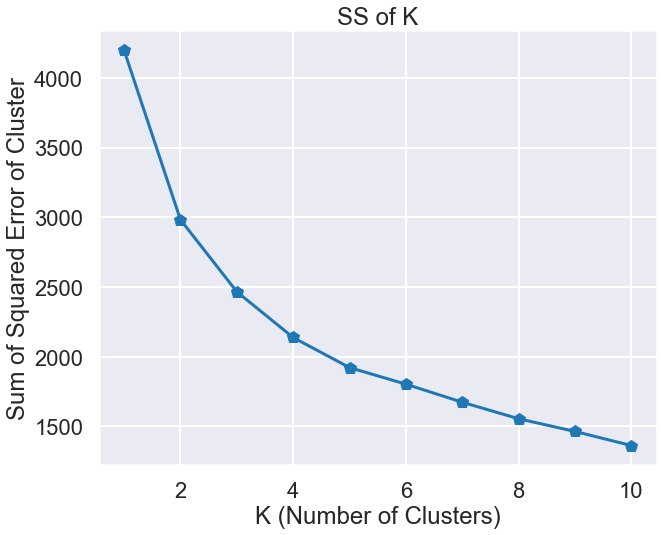

In [127]:
#Plot SS of k
plt.figure(figsize=(10,8))
plt.plot(ks, SS, marker= 'p')
plt.xlabel('K (Number of Clusters)')
plt.ylabel('Sum of Squared Error of Cluster')
plt.title('SS of K')
plt.show()

Text(0.5, 0, 'Cluster')

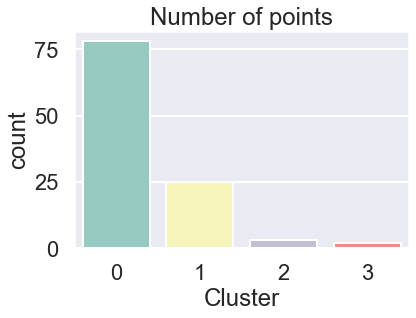

In [128]:
# Training kmeans model with the best K of 4
model_knm = KMeans(n_clusters= 4, random_state = 10).fit(x_cols)

sns.countplot(model_knm.labels_, palette = "Set3" )
plt.title("Number of points")
plt.xlabel('Cluster')

For n_clusters = 2 The average silhouette score is : 0.6689433367689573
For n_clusters = 3 The average silhouette score is : 0.5248899074341239
For n_clusters = 4 The average silhouette score is : 0.41569289607473014
For n_clusters = 5 The average silhouette score is : 0.4184739740506589
For n_clusters = 6 The average silhouette score is : 0.40790336612856753
For n_clusters = 7 The average silhouette score is : 0.3865217837039751
For n_clusters = 8 The average silhouette score is : 0.36194109056463336
For n_clusters = 9 The average silhouette score is : 0.3635782374770055
For n_clusters = 10 The average silhouette score is : 0.358405147128878


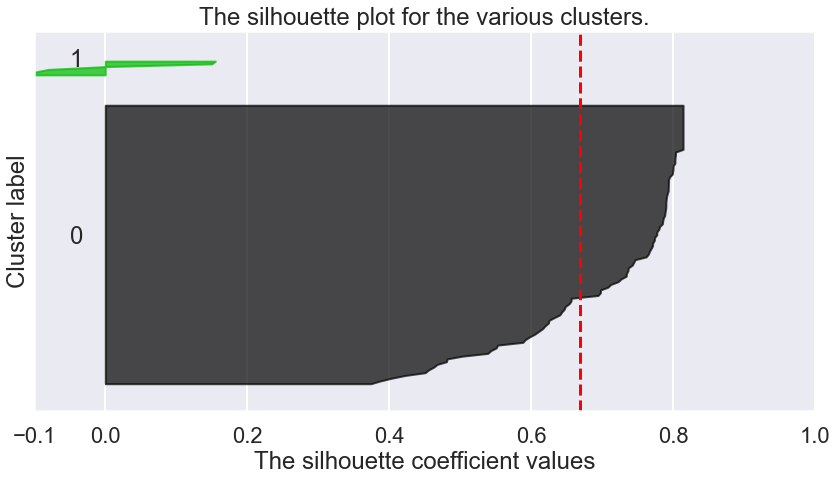

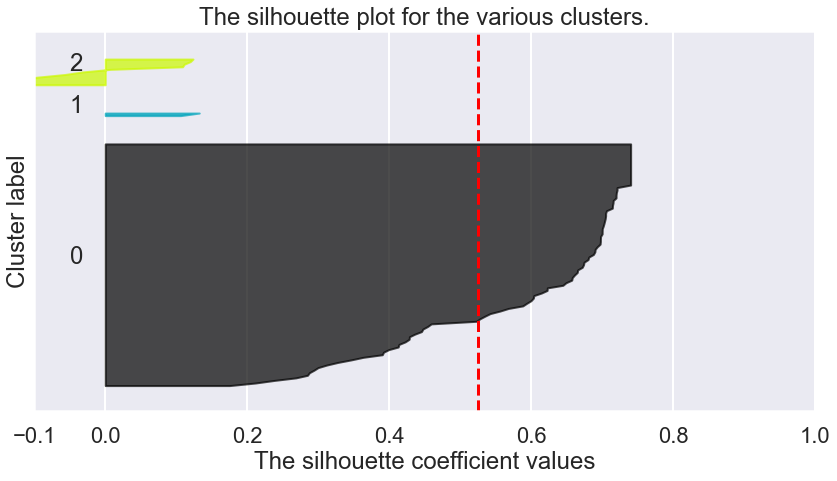

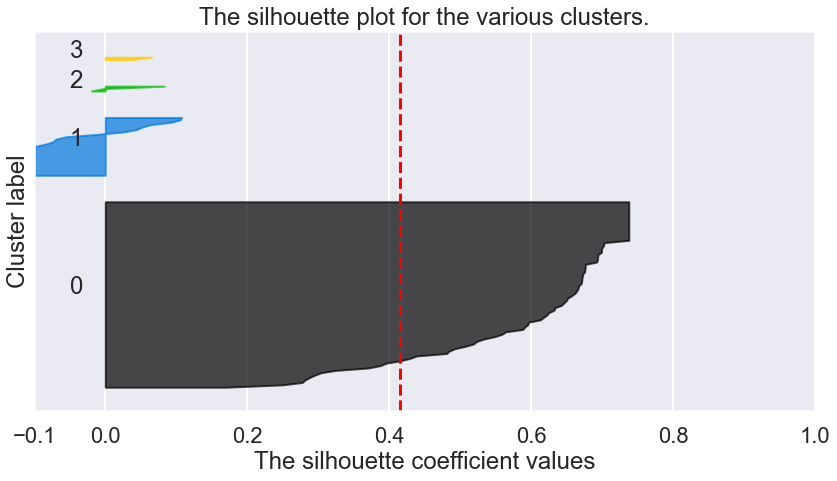

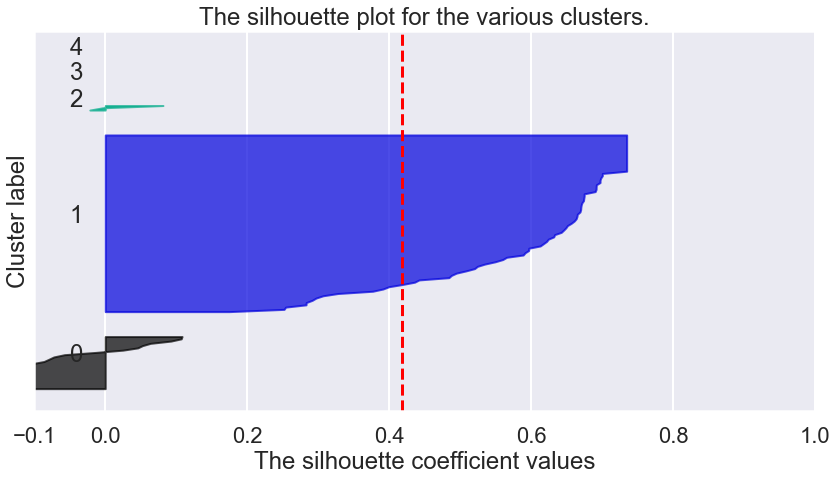

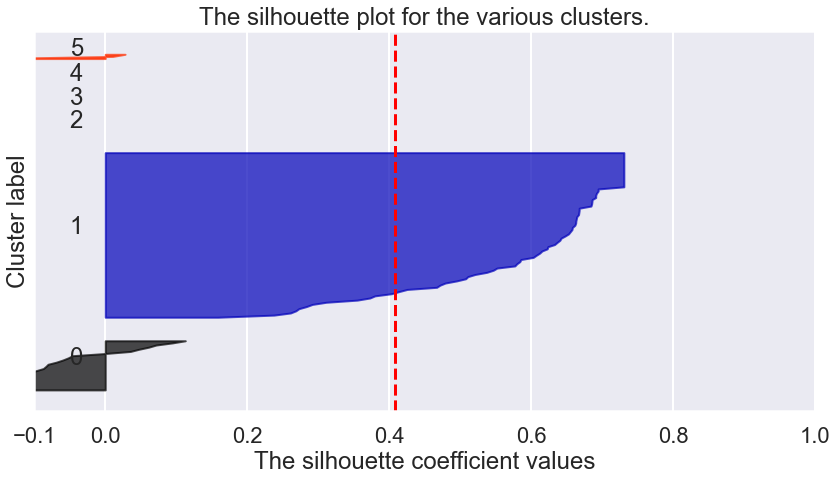

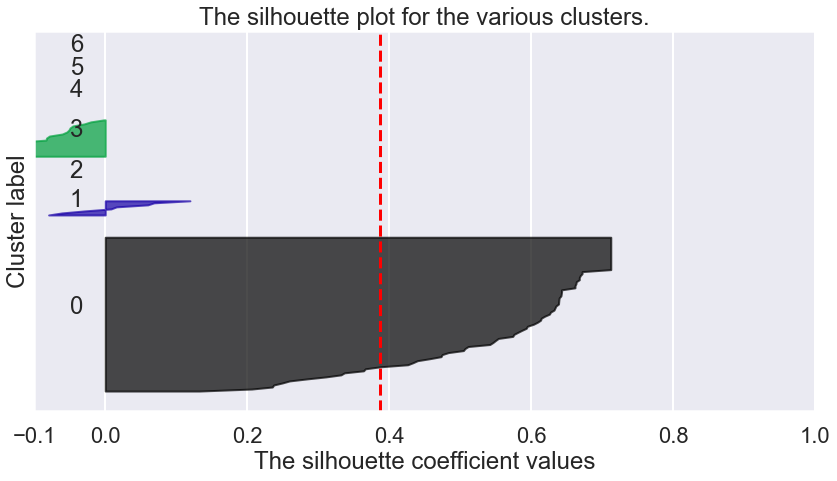

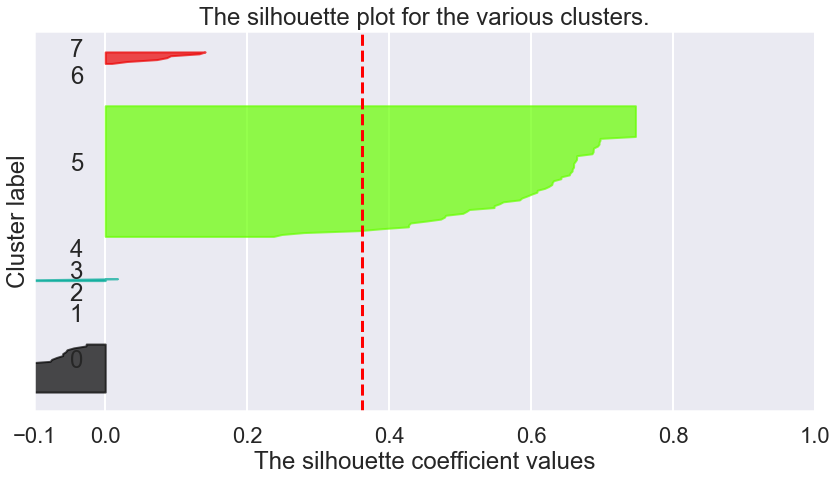

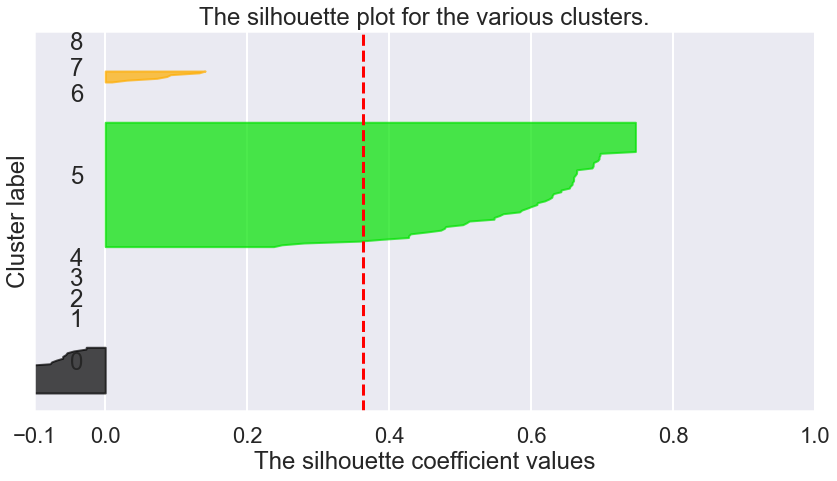

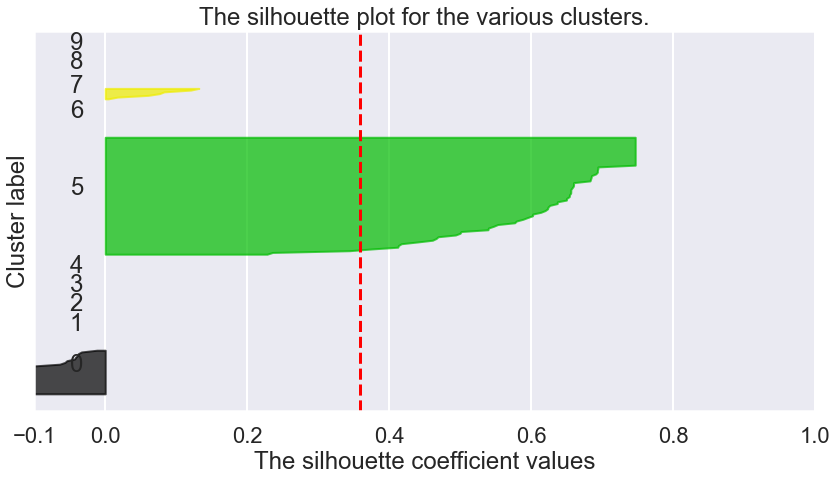

In [129]:
range_n_clusters = np.arange(2,11)
silhouette_scores = []

for n_clusters in range_n_clusters:
    #Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots(1,1)
    fig.set_size_inches(14,7)
    
    #1st subplot is the silhouette plot
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(x_cols) + (n_clusters + 1) * 10])
    
    #Initialize the cluster with n_clusters value and random state of 10
    clusterer = KMeans(n_clusters = n_clusters, random_state = 10)
    cluster_labels = clusterer.fit_predict(x_cols)
    
    #Average value for all samples through silhouette_score
    sil_avg = silhouette_score(x_cols, cluster_labels)
    silhouette_scores.append(sil_avg)
    
    print("For n_clusters =", n_clusters,
          "The average silhouette score is :", sil_avg)
    
    #Silhouette score of each sample
    sample_silhouette_values = silhouette_samples(x_cols, cluster_labels)
    
    y_lower = 10
    
    for i in range(n_clusters):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]
        
        # Sort scores for samples of cluster i 
        ith_cluster_silhouette_values.sort()
        
        # Obtain shape to add with y_lower scaling for y
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, 
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10
        
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    
     # The vertical line for average silhouette score of all the values
    ax1.axvline(x=sil_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

   

plt.show()

Text(0.5, 1.0, 'Average Silhouette Scores for $k$')

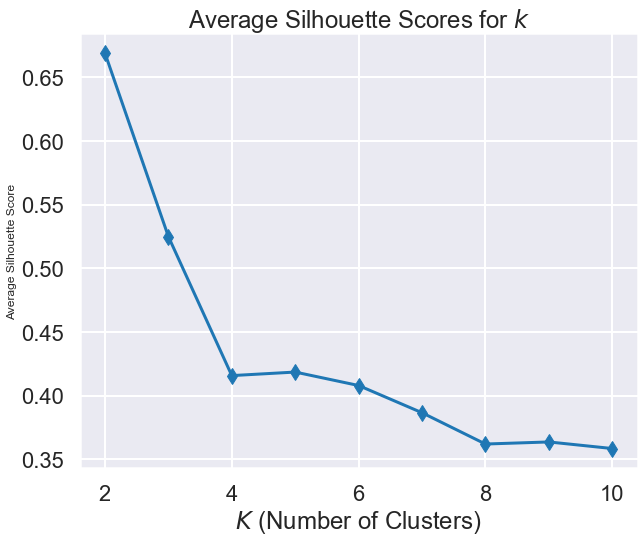

In [130]:
# Plot the Silhouette score for k = 2-10 clusters
plt.figure(figsize=(10,8))
plt.plot(range_n_clusters,silhouette_scores, marker='d')
plt.xlabel('$K$ (Number of Clusters)')
plt.ylabel('Average Silhouette Score', size = 12)
plt.title('Average Silhouette Scores for $k$')

## Visualizing Clusters using PCA

In [131]:
#Using the PCA function to reduce the dimensionality of clustering to 2 components
pca = PCA(n_components=2)
components = pca.fit_transform(x_cols)

model = KMeans(n_clusters=6, random_state=10)
labels = model.fit(x_cols).labels_

model_2 = KMeans(n_clusters=3, random_state=10)
labels_2 = model_2.fit(x_cols).labels_

df_pca = pd.DataFrame()
df_pca['Specialty'] = df_pivot.index
df_pca['Cluster_1'] = labels
df_pca['Cluster_2'] = labels_2
df_pca['x'] = components[:,0]
df_pca['y'] = components[:,1]

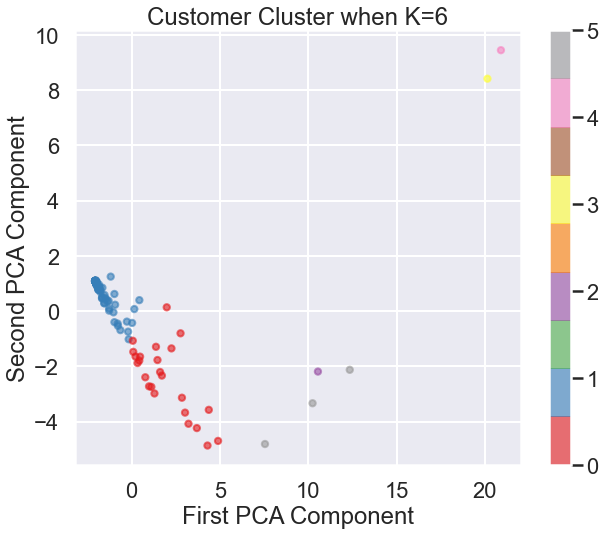

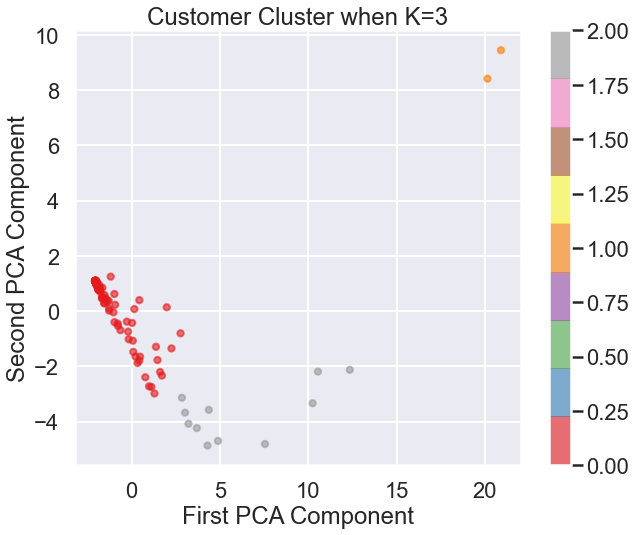

In [132]:
#plot x and y
plt.figure(figsize=(10,8))
plt.scatter(df_pca.x, df_pca.y, c=df_pca.Cluster_1, cmap='Set1', s=40, alpha=0.6)
plt.xlabel('First PCA Component')
plt.ylabel('Second PCA Component')
plt.title('Customer Cluster when K=6')
plt.colorbar()
plt.plot()

plt.figure(figsize=(10,8))
plt.scatter(df_pca.x, df_pca.y, c=df_pca.Cluster_2, cmap='Set1', s=40, alpha=0.6)
plt.xlabel('First PCA Component')
plt.ylabel('Second PCA Component')
plt.title('Customer Cluster when K=3')
plt.colorbar()
plt.plot();

***$K$=3 and $K$=6 seem to both have closer clusters with some outliers***

In [133]:
#Create merged DataFrame
df_main = pd.merge(df_merge, df_pca, on='Specialty')
df_main.sort_values('Cluster_2').head()

,NPI,Specialty,Spec_group,N,Abbrev,Region,Opioid.Prescriber,Population,Gender,SumOpi,Cluster_1,Cluster_2,x,y
24758,1720095482,Unknown Supplier/Provider,group4,1,ND,Central,1,723393,M,24,1,0,-2.003162,1.001359
17626,1063470250,Dermatology,group1,1,AL,South,0,4833722,F,0,0,0,0.224853,-1.648549
17627,1356639934,Dermatology,group1,1,NY,North East,0,19651127,F,0,0,0,0.224853,-1.648549
17628,1609956598,Dermatology,group1,1,NY,North East,0,19651127,M,0,0,0,0.224853,-1.648549
17629,1215014683,Dermatology,group1,1,NY,North East,0,19651127,F,0,0,0,0.224853,-1.648549


(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

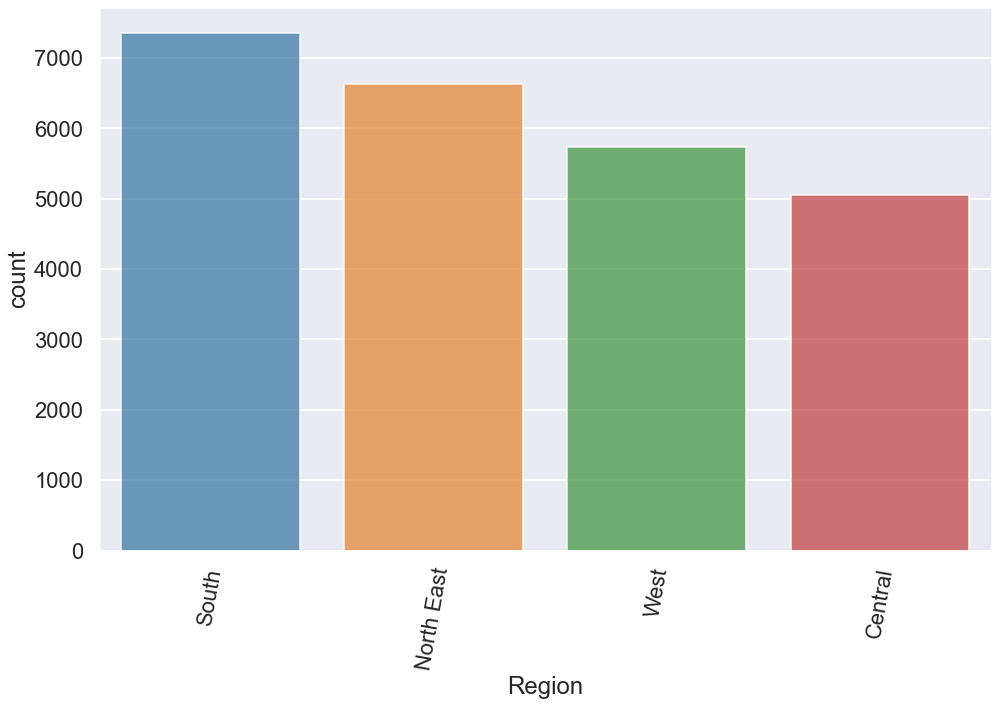

In [134]:
plt.figure(figsize=(16,10))
sns.countplot(x='Region',data=df_main,alpha=0.7)
plt.xticks(rotation=80)

(array([0, 1]), <a list of 2 Text major ticklabel objects>)

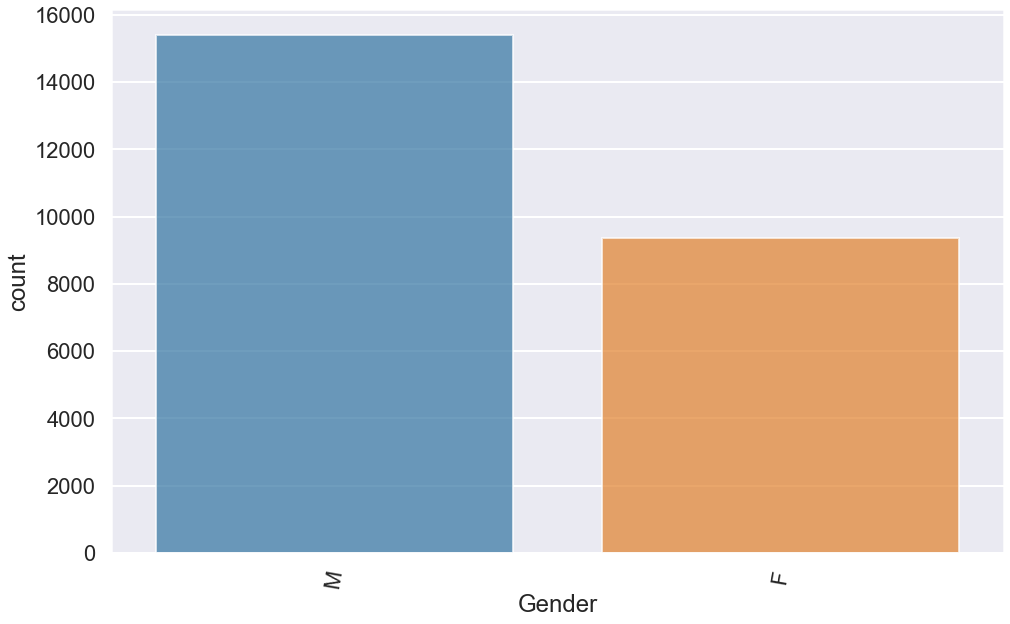

In [135]:
plt.figure(figsize=(16,10))
sns.countplot(x='Gender', data=df_main,alpha=0.7)
plt.xticks(rotation=80)

(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

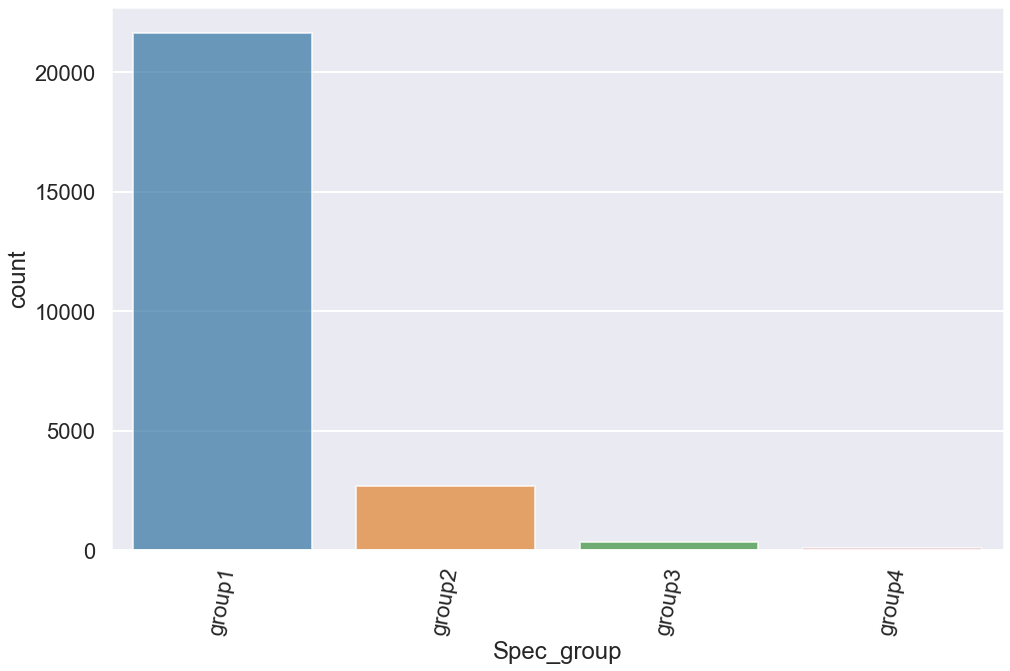

In [136]:
plt.figure(figsize=(16,10))
sns.countplot(x='Spec_group', data=df_main,alpha=0.7)
plt.xticks(rotation=80)

[]

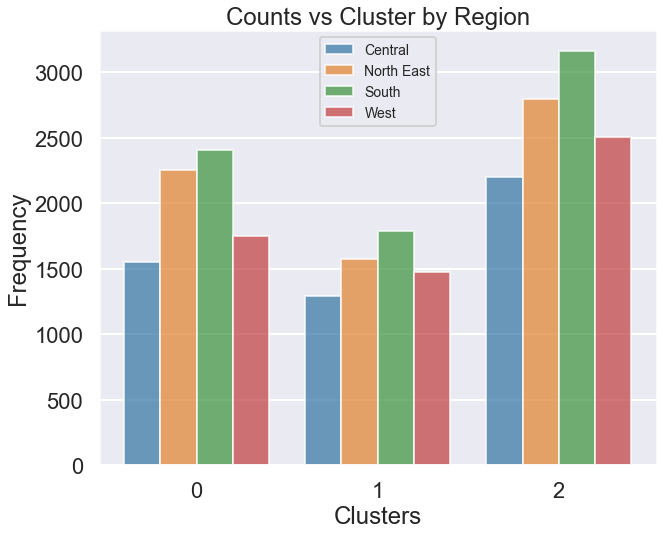

In [137]:
clust_group = df_main.groupby(['Cluster_2', 'Region']).Specialty.count().reset_index()

plt.figure(figsize=(10,8))
sns.barplot(x='Cluster_2', y='Specialty', data=clust_group, hue='Region', alpha=0.7)
plt.xlabel('Clusters')
plt.ylabel('Frequency')
plt.title('Counts vs Cluster by Region')
plt.legend(loc= 'upper center', prop={'size': 14})
plt.plot()

Each cluster seemed to have a have the same components leading the clusters. Group1 for Specialties is mostly made up of the specialsts who have higher opioid prescriptions given. In regards to the Regions, the states located in the South lead the way in the various clusters as well.

[]

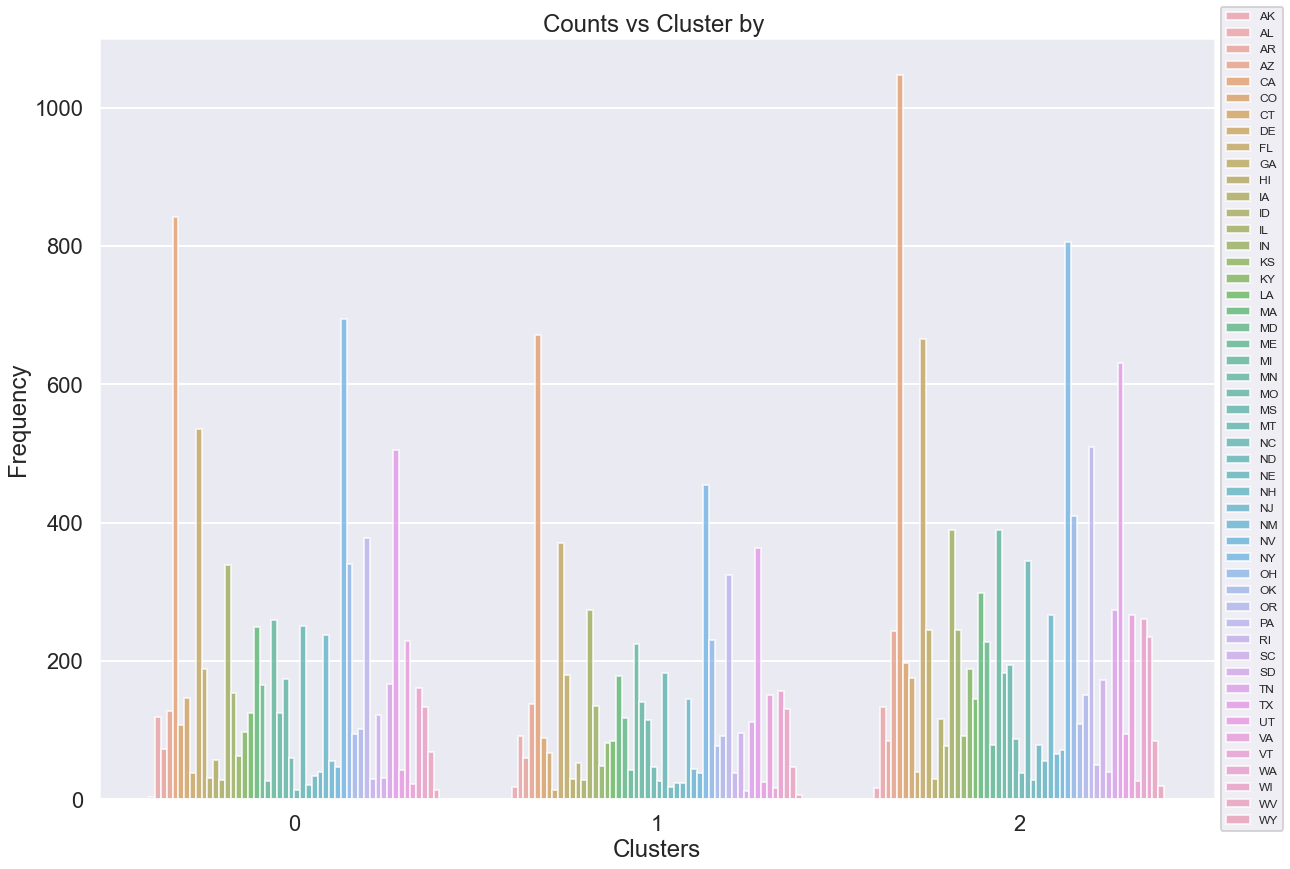

In [138]:
clust_group1 = df_main.groupby(['Cluster_2', 'Abbrev']).Specialty.count().reset_index()

plt.figure(figsize=(20,14))
sns.barplot(x='Cluster_2', y='Specialty', data=clust_group1, hue='Abbrev', alpha=0.7)
plt.xlabel('Clusters')
plt.ylabel('Frequency')
plt.title('Counts vs Cluster by ')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 12})
plt.plot()

[]

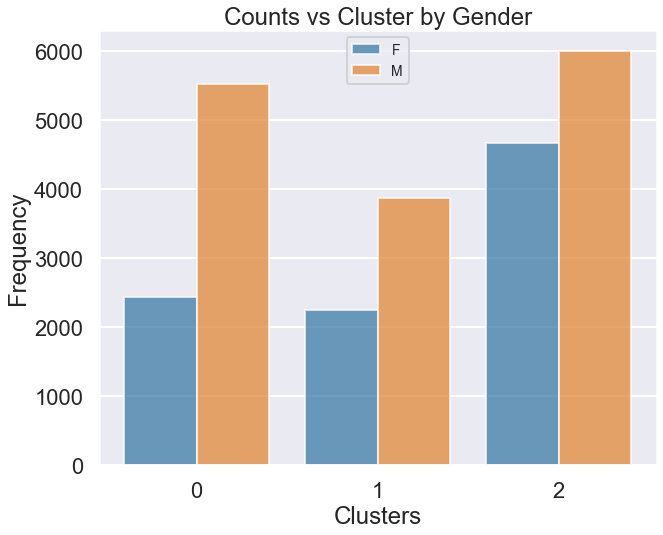

In [139]:
clust_group11 = df_main.groupby(['Cluster_2', 'Gender']).Specialty.count().reset_index()

plt.figure(figsize=(10,8))
sns.barplot(x='Cluster_2', y='Specialty', data=clust_group11, hue='Gender', alpha=0.7)
plt.xlabel('Clusters')
plt.ylabel('Frequency')
plt.title('Counts vs Cluster by Gender')
plt.legend(loc= 'upper center', prop={'size': 14})
plt.plot()

Not much of a surprise here as our dataset is Male dominate

[]

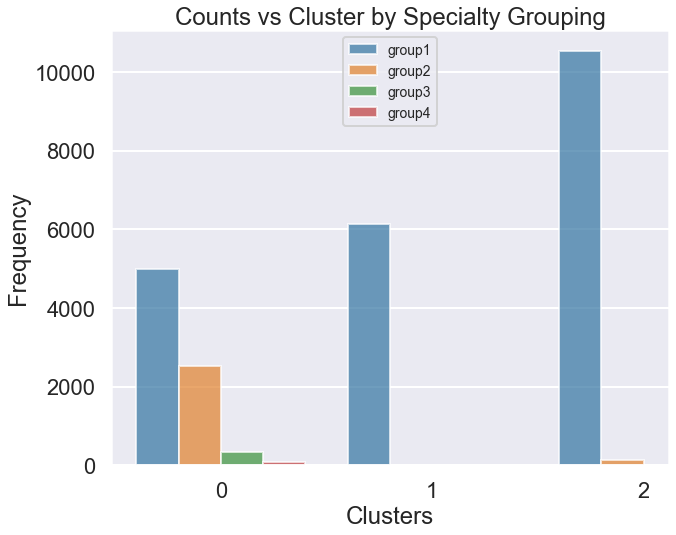

In [140]:
clust_group12 = df_main.groupby(['Cluster_2', 'Spec_group']).Specialty.count().reset_index()

plt.figure(figsize=(10,8))
sns.barplot(x='Cluster_2', y='Specialty', data=clust_group12, hue='Spec_group', alpha=0.7)
plt.xlabel('Clusters')
plt.ylabel('Frequency')
plt.title('Counts vs Cluster by Specialty Grouping')
plt.legend(loc= 'upper center', prop={'size': 14})
plt.plot()

The clusters look to be the same in regards to group 1 leading the way.

(0.0, 10.0)

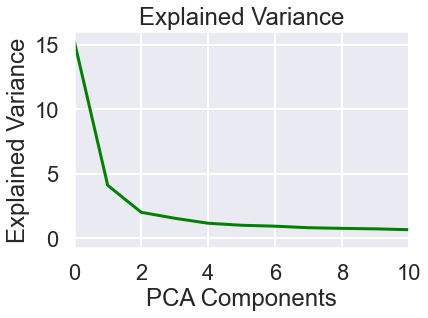

In [145]:
# Initialize a new PCA model with a default number of components.
pca = sklearn.decomposition.PCA()
pca.fit(x_cols)

# Do the rest on your own :)
plt.plot(pca.explained_variance_, c='g', linewidth=3)
plt.title('Explained Variance')
plt.xlabel('PCA Components')
plt.ylabel('Explained Variance')
plt.xlim([0, 10])

The elbow curve looks to be at 1

### Other Clustering Algorithms

In [915]:
from sklearn.cluster import AffinityPropagation, SpectralClustering, AgglomerativeClustering, DBSCAN
algorithms = ['AffinityPropagation', 'SpectralClustering', 'AgglomerativeClustering', 'DBSCAN']
algorithm_silscores = pd.Series(index=algorithms)

In [916]:
#Affinity Propagation (x_cols)

#find the best value for damping parameter. 
dampings = [0.5, 0.6, 0.7, 0.8, 0.9]
best_score = 0.0
for damping in dampings:
    ap = AffinityPropagation(damping=damping)
    labels = ap.fit_predict(x_cols)
    silhouette_avg = silhouette_score(x_cols, labels, random_state=10)
    print("For damping =", damping,
          "The average silhouette_score is :", silhouette_avg)
    if silhouette_avg > best_score:
        best_score = silhouette_avg
        best_damping = damping
        
print('Best damping parameter:', best_damping)
algorithm_silscores.loc['AffinityPropagation'] = best_score

For damping = 0.5 The average silhouette_score is : 0.21014605803802652
For damping = 0.6 The average silhouette_score is : 0.21014605803802652
For damping = 0.7 The average silhouette_score is : -0.25396501746883904
For damping = 0.8 The average silhouette_score is : 0.36262784018379857
For damping = 0.9 The average silhouette_score is : 0.36262784018379857
Best damping parameter: 0.8


In [917]:
#Spectral Clustering (x_cols)

#find the best value for n_clusters parameter. 
range_n_clusters = range(2,11)
best_score = 0.0
for n_clusters in range_n_clusters:
    sc = SpectralClustering(n_clusters=n_clusters)
    labels = sc.fit_predict(x_cols)
    silhouette_avg = silhouette_score(x_cols, labels, random_state=10)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    if silhouette_avg > best_score:
        best_score = silhouette_avg
        best_n_clusters = n_clusters
        
print('Best n_clusters parameter:',best_n_clusters)
algorithm_silscores.loc['SpectralClustering'] = best_score

For n_clusters = 2 The average silhouette_score is : 0.7419587644439746
For n_clusters = 3 The average silhouette_score is : 0.73486682160799
For n_clusters = 4 The average silhouette_score is : 0.7419587644439746
For n_clusters = 5 The average silhouette_score is : 0.73486682160799
For n_clusters = 6 The average silhouette_score is : 0.7419587644439746
For n_clusters = 7 The average silhouette_score is : 0.73486682160799
For n_clusters = 8 The average silhouette_score is : 0.73486682160799
For n_clusters = 9 The average silhouette_score is : 0.73486682160799
For n_clusters = 10 The average silhouette_score is : 0.73486682160799
Best n_clusters parameter: 2


In [918]:
#Agglomerative Clustering (x_cols)

#find the best value for n_clusters parameter. 
range_n_clusters = range(2,11)
best_score = 0.0
for n_clusters in range_n_clusters:
    ac = AgglomerativeClustering(n_clusters=n_clusters)
    labels = ac.fit_predict(x_cols)
    silhouette_avg = silhouette_score(x_cols, labels, random_state=10)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    if silhouette_avg > best_score:
        best_score = silhouette_avg
        best_n_clusters = n_clusters
        
print('Best n_clusters parameter:',best_n_clusters)
algorithm_silscores.loc['AgglomerativeClustering'] = best_score

For n_clusters = 2 The average silhouette_score is : 0.7419587644439746
For n_clusters = 3 The average silhouette_score is : 0.42589301129376017
For n_clusters = 4 The average silhouette_score is : 0.4134845619598322
For n_clusters = 5 The average silhouette_score is : 0.4125525105088719
For n_clusters = 6 The average silhouette_score is : 0.39212457625310077
For n_clusters = 7 The average silhouette_score is : 0.39246507927813723
For n_clusters = 8 The average silhouette_score is : 0.39319327850974667
For n_clusters = 9 The average silhouette_score is : 0.3880016285548554
For n_clusters = 10 The average silhouette_score is : 0.37005677799160785
Best n_clusters parameter: 2


In [919]:
#DBSCAN (x_cols)

#find the best value for min_samples parameter. 
range_min_samples = [1, 2, 3]
best_score = 0.0
for min_samples in range_min_samples:
    db = DBSCAN(min_samples=min_samples)
    labels = db.fit_predict(x_cols)
    silhouette_avg = silhouette_score(x_cols, labels, random_state=10)
    print("For min_samples =", min_samples,
          "The average silhouette_score is :", silhouette_avg)
    if silhouette_avg > best_score:
        best_score = silhouette_avg
        best_min_samples = min_samples
        
print('Best min_samples parameter:',best_min_samples)
algorithm_silscores.loc['DBSCAN'] = best_score

For min_samples = 1 The average silhouette_score is : 0.19444444444444445
For min_samples = 2 The average silhouette_score is : -0.1385581028936826
For min_samples = 3 The average silhouette_score is : -0.19197235347699468
Best min_samples parameter: 1


In [920]:
print(algorithm_silscores)

AffinityPropagation        0.362628
SpectralClustering         0.741959
AgglomerativeClustering    0.741959
DBSCAN                     0.194444
dtype: float64


The clustering algorithms offer different results with Agglomerative Clustering and Spectral Clustering offering the highest silhouette score. None of the scores offer high enough scores though.

### 5b. Clustering with Specialty and NonOpi columns (NonOpi = total sum of non opioids prescribed per each specialists)

In [173]:
df_call2 = prescriber[['NPI', 'Abbrev', 'Region', 'Opioid.Prescriber', 'Population', 'Gender', 'NonOpi']]
df_merge2 = pd.merge(df_new, df_call2, how='left', on='NPI')

In [174]:
df_pivot2 = df_merge2.pivot_table(index='Specialty', columns='NonOpi', values='N').fillna(0)

In [175]:
df_pivot2

NonOpi,0,11,12,13,14,15,16,17,18,19,...,36836,37485,37919,40738,42618,43419,43702,44138,50628,54958
Specialty,,,,,,,,,,,,,,,,,,,,,
Addiction Medicine,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Allergy/Immunology,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Anesthesiology,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Behavioral Analyst,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CRNA,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Thoracic Surgery (Cardiothoracic Vascular Surgery),0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Unknown Physician Specialty Code,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Unknown Supplier/Provider,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [176]:
x_cols2 = df_pivot2.values
x_cols2[:5,:]

array([[1., 0., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.]])

In [177]:
model2 = KMeans(n_clusters = 5, random_state = 0)
model2.fit(x_cols2)

print(model2.labels_)
print(model2.cluster_centers_)
print(model2.inertia_)

[1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 4 0 1 4 1 1 2 0 1 1 0 1 1 1 1 1 1 0 1
 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 4 4 0 4 1 0 1 4 1 0 1 1
 1 1 1 1 1 4 1 1 4 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 4 1 1 1 1 1 1 1 1]
[[ 6.36363636e-01  9.09090909e-01  8.18181818e-01 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 5.11627907e-01  5.34883721e-01  4.88372093e-01 ... -8.67361738e-18
  -8.67361738e-18 -8.67361738e-18]
 [ 1.00000000e+00  1.00000000e+00  1.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.00000000e+00]
 [ 1.00000000e+00  1.00000000e+00  1.00000000e+00 ...  1.00000000e+00
   1.00000000e+00  0.00000000e+00]
 [ 8.88888889e-01  1.00000000e+00  1.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]
6885.738900634249


In [178]:
ks2 = np.arange(1,11)
SS2 = []

for k in ks2:
    model2 = KMeans(n_clusters = k, random_state = 10)
    model2.fit(x_cols2)
    SS2.append(model2.inertia_)

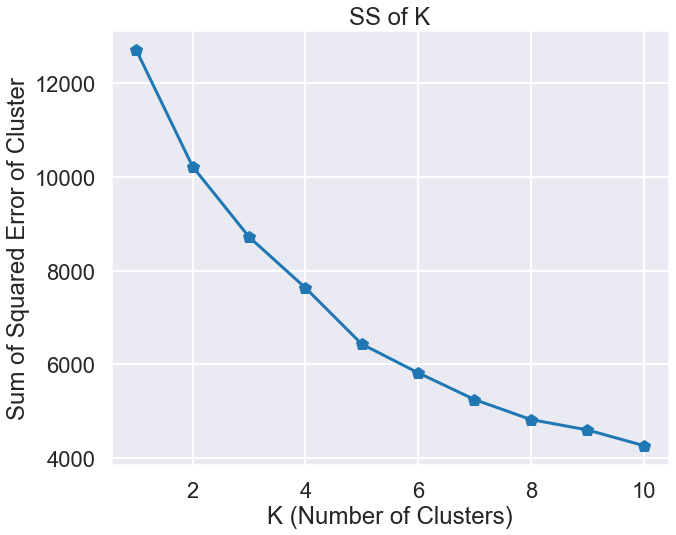

In [179]:
#Plot SS of k
plt.figure(figsize=(10,8))
plt.plot(ks2, SS2, marker= 'p')
plt.xlabel('K (Number of Clusters)')
plt.ylabel('Sum of Squared Error of Cluster')
plt.title('SS of K')
plt.show()

The challenge with the Elbow method is picking the correction location of $K$. In this case, the elbow slope wasn't pronounced enough to easily pick the proper location.

In [180]:
#Using the PCA function to reduce the dimensionality of clustering to 2 components
pca2 = PCA(n_components=2)
components2 = pca.fit_transform(x_cols2)

model2 = KMeans(n_clusters=6, random_state=10)
labels2 = model.fit(x_cols).labels_

model_2_non = KMeans(n_clusters=3, random_state=10)
labels_2_non = model_2.fit(x_cols).labels_

df_pca2 = pd.DataFrame()
df_pca2['Specialty'] = df_pivot2.index
df_pca2['Cluster_1'] = labels2
df_pca2['Cluster_2'] = labels_2_non
df_pca2['x'] = components[:,0]
df_pca2['y'] = components[:,1]

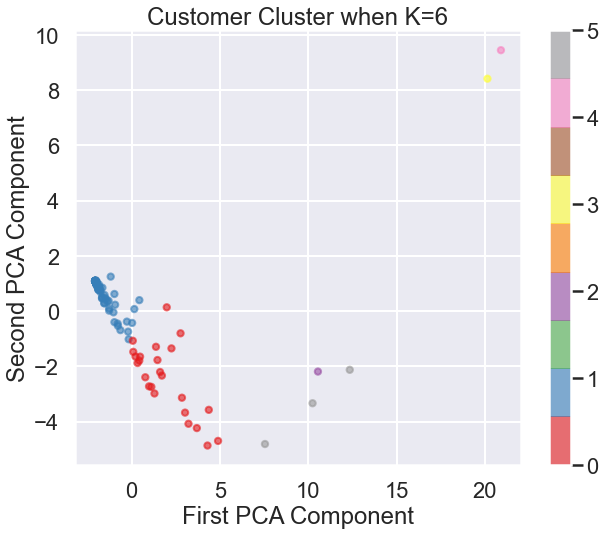

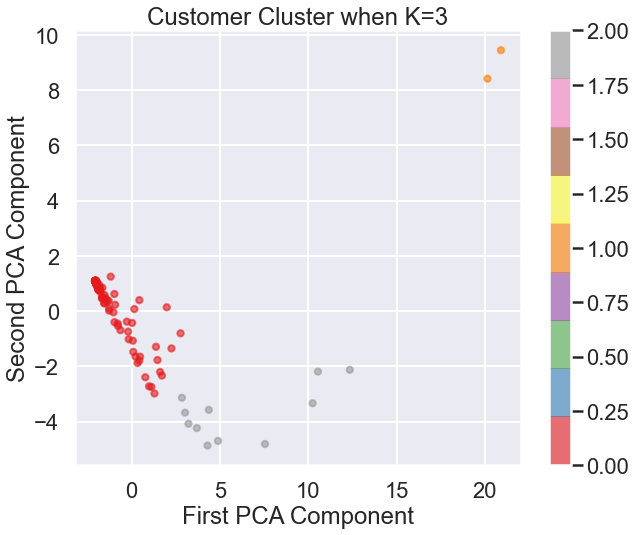

In [181]:
#plot x and y
plt.figure(figsize=(10,8))
plt.scatter(df_pca2.x, df_pca2.y, c=df_pca2.Cluster_1, cmap='Set1', s=40, alpha=0.6)
plt.xlabel('First PCA Component')
plt.ylabel('Second PCA Component')
plt.title('Customer Cluster when K=6')
plt.colorbar()
plt.plot()

plt.figure(figsize=(10,8))
plt.scatter(df_pca2.x, df_pca2.y, c=df_pca2.Cluster_2, cmap='Set1', s=40, alpha=0.6)
plt.xlabel('First PCA Component')
plt.ylabel('Second PCA Component')
plt.title('Customer Cluster when K=3')
plt.colorbar()
plt.plot();

***$K$=3 seems and $K$=6 seem to both have closer clusters with some outliers***

Text(0.5, 0, 'Cluster')

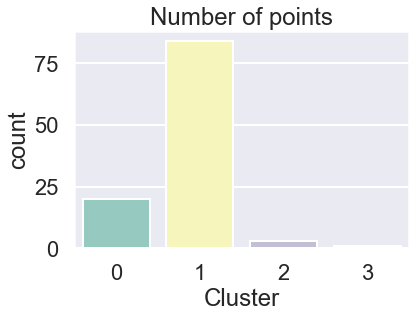

In [182]:
# Training kmeans model with the best K of 4
model_knm2 = KMeans(n_clusters= 4, random_state = 10).fit(x_cols2)

sns.countplot(model_knm2.labels_, palette = "Set3" )
plt.title("Number of points")
plt.xlabel('Cluster')

For n_clusters = 2 The average silhouette score is : 0.7303626094064972
For n_clusters = 3 The average silhouette score is : 0.7488355496134914
For n_clusters = 4 The average silhouette score is : 0.44643811937617195
For n_clusters = 5 The average silhouette score is : 0.45368446242244354
For n_clusters = 6 The average silhouette score is : 0.4620930437742316
For n_clusters = 7 The average silhouette score is : 0.44529819937434606
For n_clusters = 8 The average silhouette score is : 0.44947489898226217
For n_clusters = 9 The average silhouette score is : 0.451767128738348
For n_clusters = 10 The average silhouette score is : 0.4457255153451655


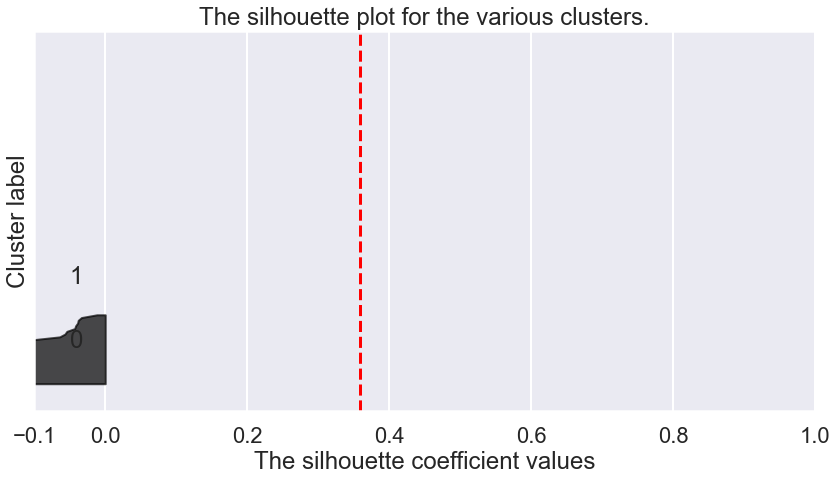

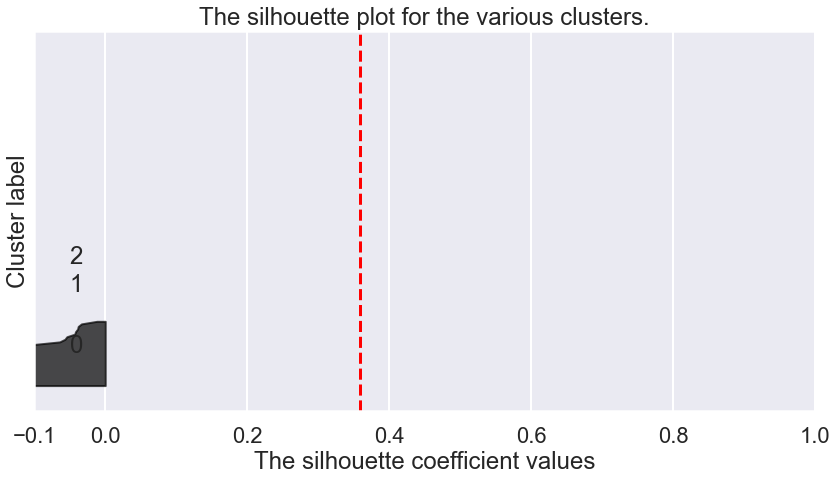

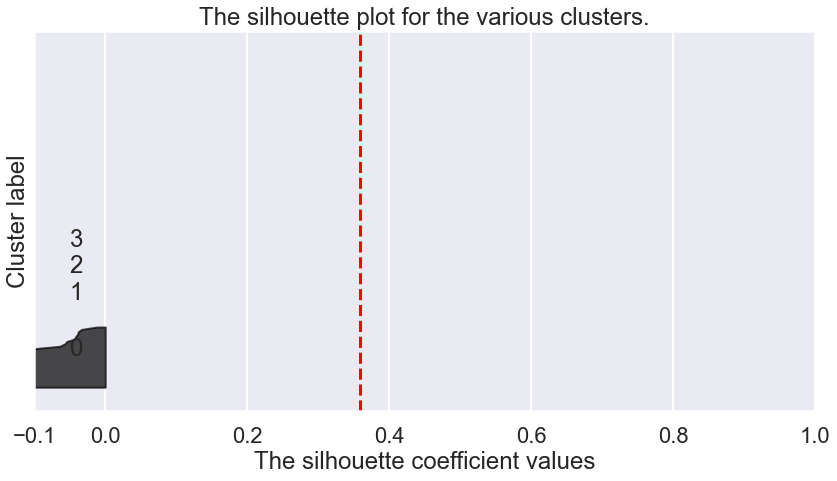

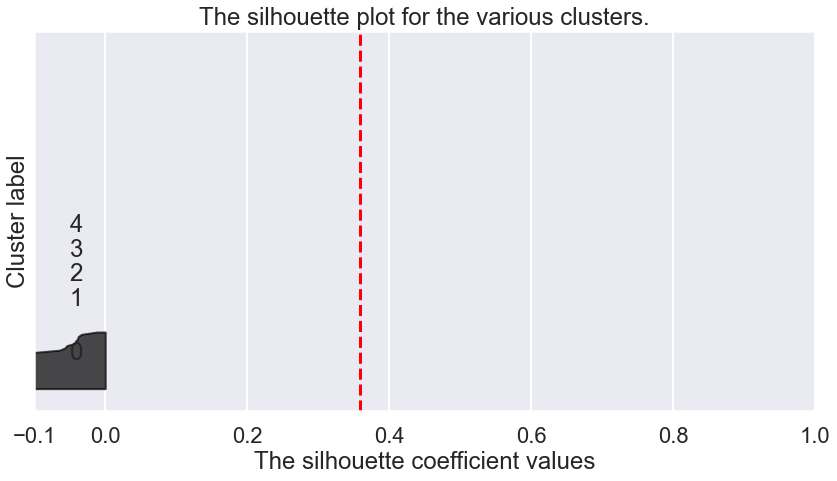

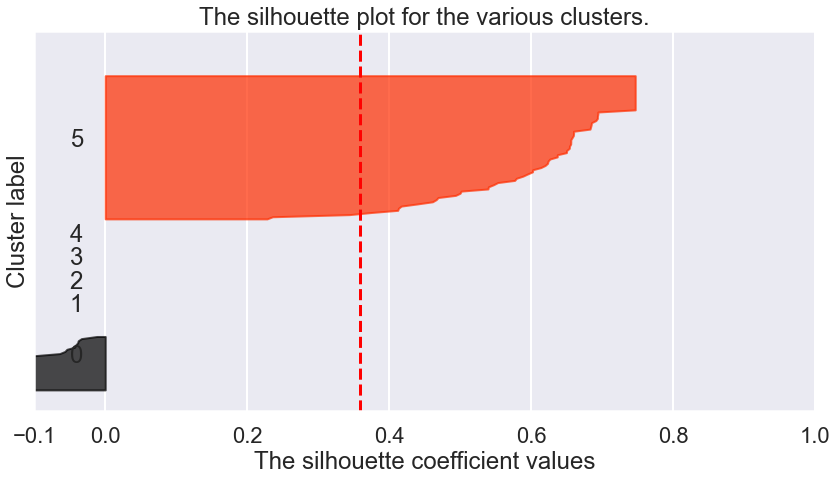

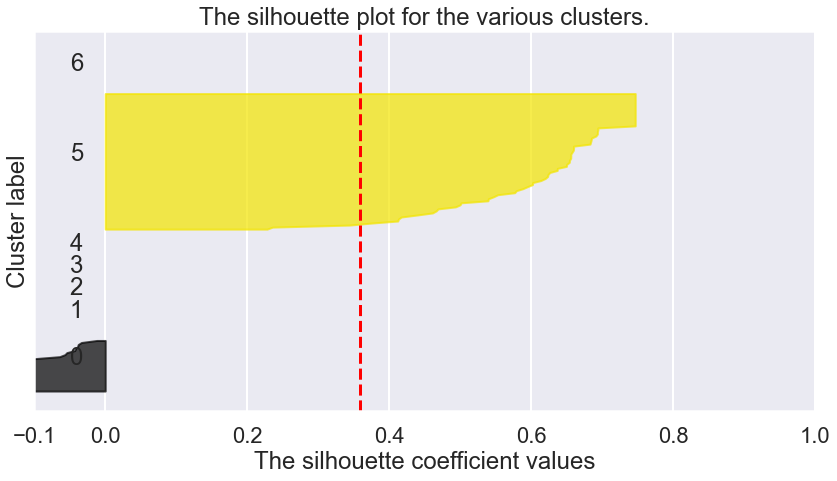

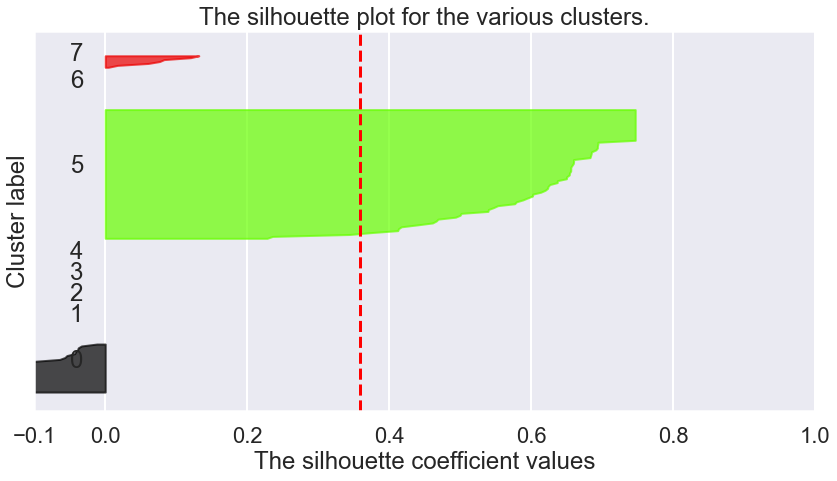

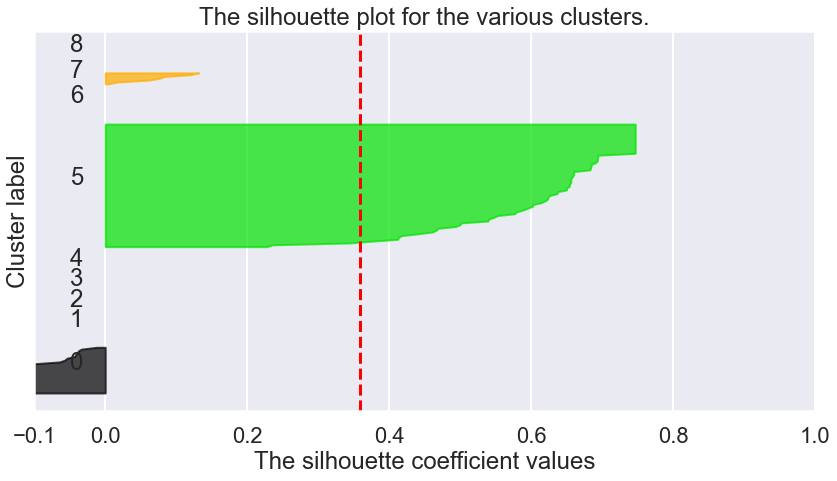

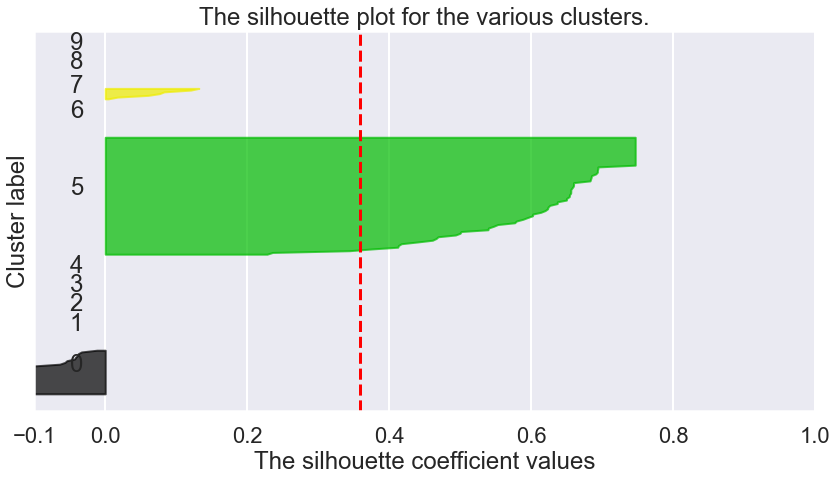

In [183]:
range_n_clusters2 = np.arange(2,11)
silhouette_scores2 = []

for n_clusters in range_n_clusters:
    #Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots(1,1)
    fig.set_size_inches(14,7)
    
    #1st subplot is the silhouette plot
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(x_cols) + (n_clusters + 1) * 10])
    
    #Initialize the cluster with n_clusters value and random state of 10
    clusterer = KMeans(n_clusters = n_clusters, random_state = 10)
    cluster_labels2 = clusterer.fit_predict(x_cols2)
    
    #Average value for all samples through silhouette_score
    sil_avg2 = silhouette_score(x_cols2, cluster_labels2)
    silhouette_scores2.append(sil_avg2)
    
    print("For n_clusters =", n_clusters,
          "The average silhouette score is :", sil_avg2)
    
    #Silhouette score of each sample
    sample_silhouette_values2 = silhouette_samples(x_cols2, cluster_labels2)
    
    y_lower = 10
    
    for i in range(n_clusters):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]
        
        # Sort scores for samples of cluster i 
        ith_cluster_silhouette_values.sort()
        
        # Obtain shape to add with y_lower scaling for y
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, 
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10
        
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    
     # The vertical line for average silhouette score of all the values
    ax1.axvline(x=sil_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

   

plt.show()

Text(0.5, 1.0, 'Average Silhouette Scores for $k$')

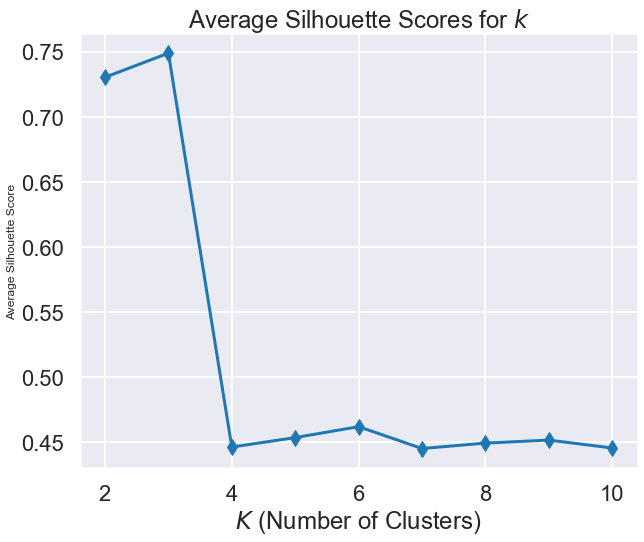

In [184]:
# Plot the Silhouette score for k = 2-10 clusters
plt.figure(figsize=(10,8))
plt.plot(range_n_clusters2,silhouette_scores2, marker='d')
plt.xlabel('$K$ (Number of Clusters)')
plt.ylabel('Average Silhouette Score', size = 12)
plt.title('Average Silhouette Scores for $k$')

Silhouette method suggests that the $K$ value of 3 is the best value to choose since it has the highest score at 0.75.

## Visualizing Clusters using PCA

In [185]:
#Create merged DataFrame
df_main2 = pd.merge(df_merge2, df_pca2, on='Specialty')
df_main2.sort_values('Cluster_2').head()

,NPI,Specialty,Spec_group,N,Abbrev,Region,Opioid.Prescriber,Population,Gender,NonOpi,Cluster_1,Cluster_2,x,y
24758,1720095482,Unknown Supplier/Provider,group4,1,ND,Central,1,723393,M,252,1,0,-2.003162,1.001359
17626,1063470250,Dermatology,group1,1,AL,South,0,4833722,F,494,0,0,0.224853,-1.648549
17627,1356639934,Dermatology,group1,1,NY,North East,0,19651127,F,61,0,0,0.224853,-1.648549
17628,1609956598,Dermatology,group1,1,NY,North East,0,19651127,M,44,0,0,0.224853,-1.648549
17629,1215014683,Dermatology,group1,1,NY,North East,0,19651127,F,11,0,0,0.224853,-1.648549


(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

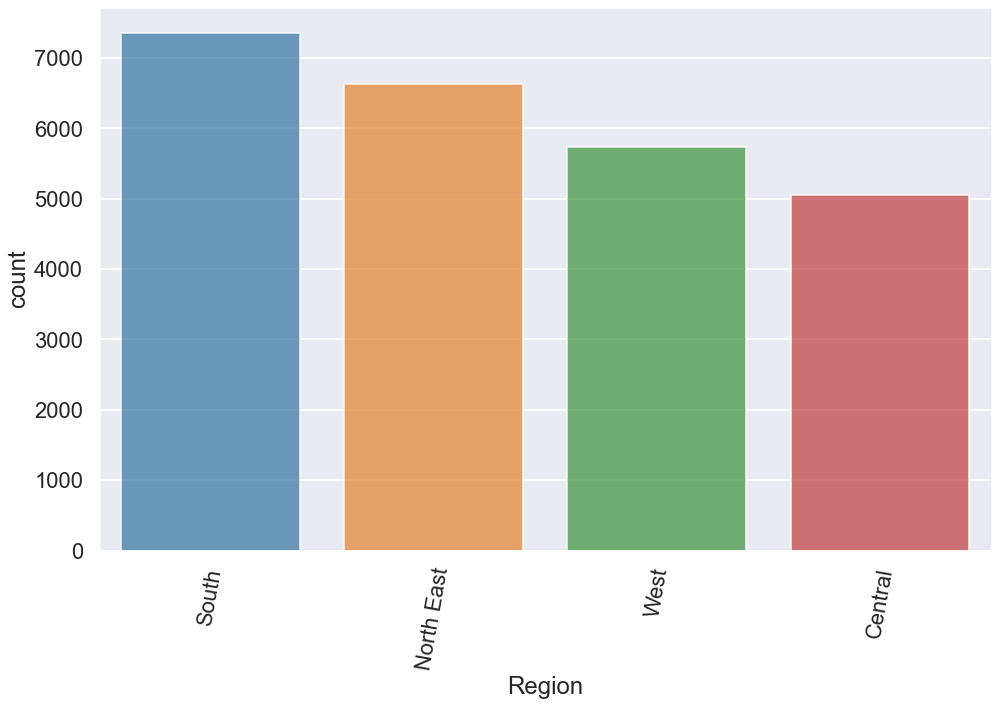

In [186]:
plt.figure(figsize=(16,10))
sns.countplot(x='Region',data=df_main2,alpha=0.7)
plt.xticks(rotation=80)

(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

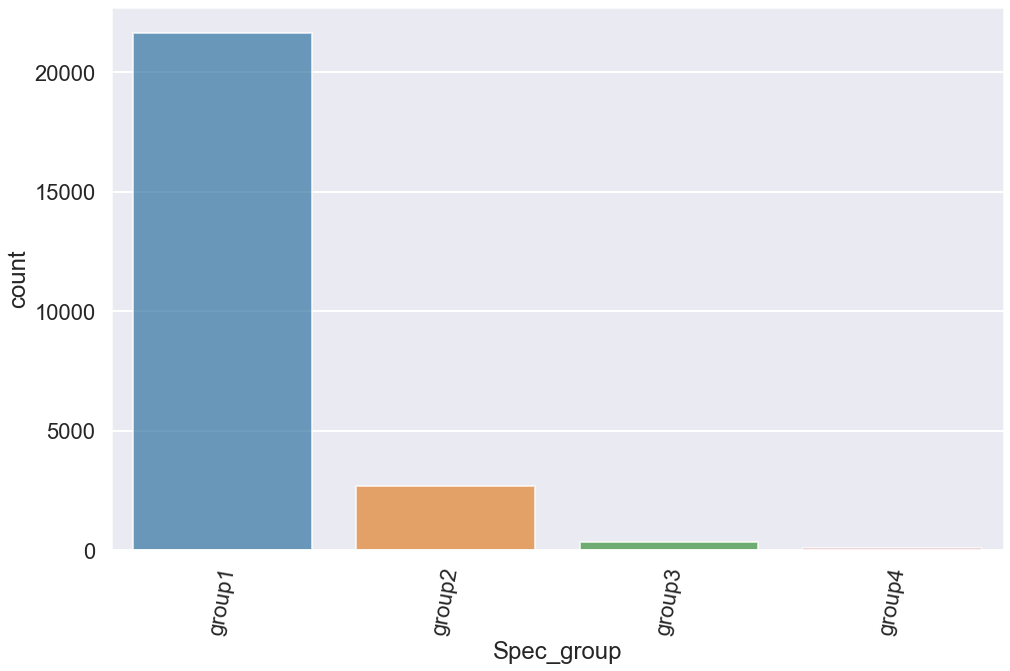

In [187]:
plt.figure(figsize=(16,10))
sns.countplot(x='Spec_group',data=df_main2,alpha=0.7)
plt.xticks(rotation=80)

(array([0, 1]), <a list of 2 Text major ticklabel objects>)

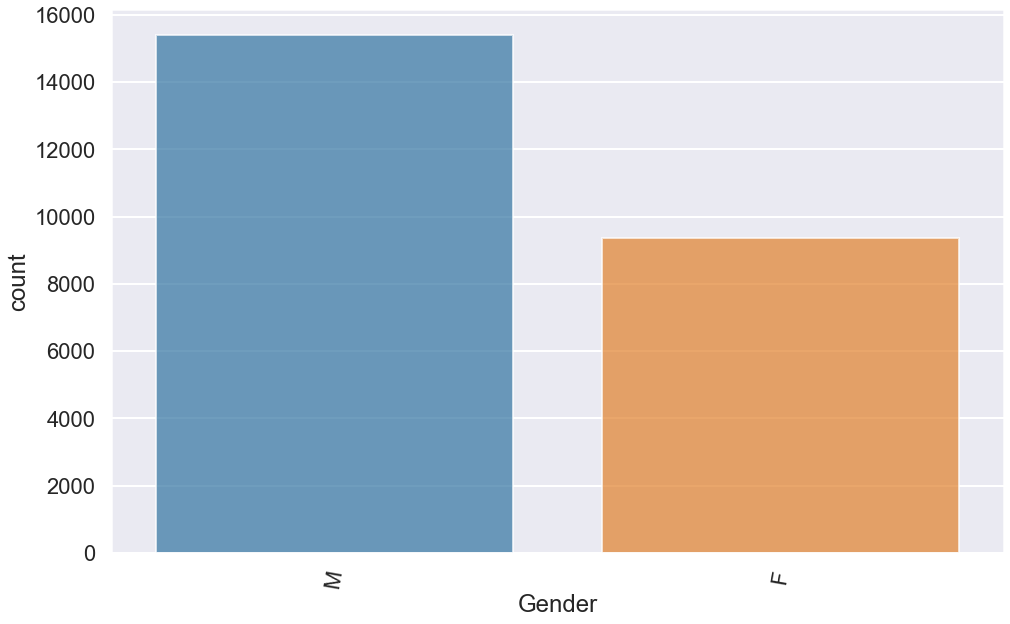

In [188]:
plt.figure(figsize=(16,10))
sns.countplot(x='Gender', data=df_main2,alpha=0.7)
plt.xticks(rotation=80)

[]

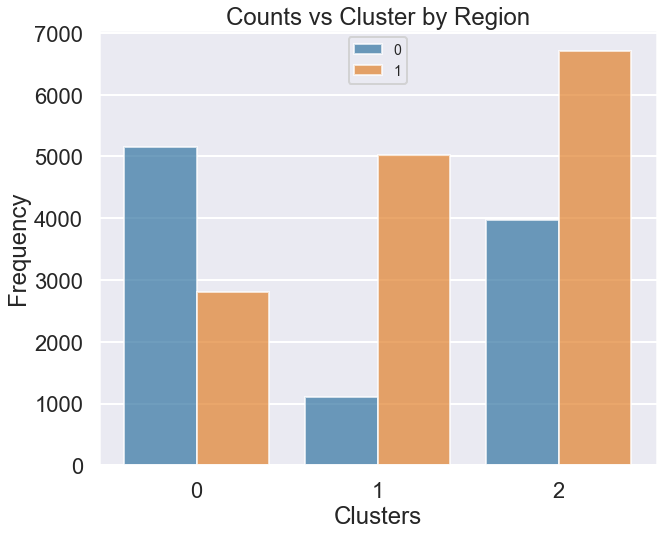

In [193]:
clust_group21 = df_main2.groupby(['Cluster_2', 'Opioid.Prescriber']).Specialty.count().reset_index()

plt.figure(figsize=(10,8))
sns.barplot(x='Cluster_2', y='Specialty', data=clust_group21, hue='Opioid.Prescriber', alpha=0.7)
plt.xlabel('Clusters')
plt.ylabel('Frequency')
plt.title('Counts vs Cluster by Region')
plt.legend(loc= 'upper center', prop={'size': 14})
plt.plot()

[]

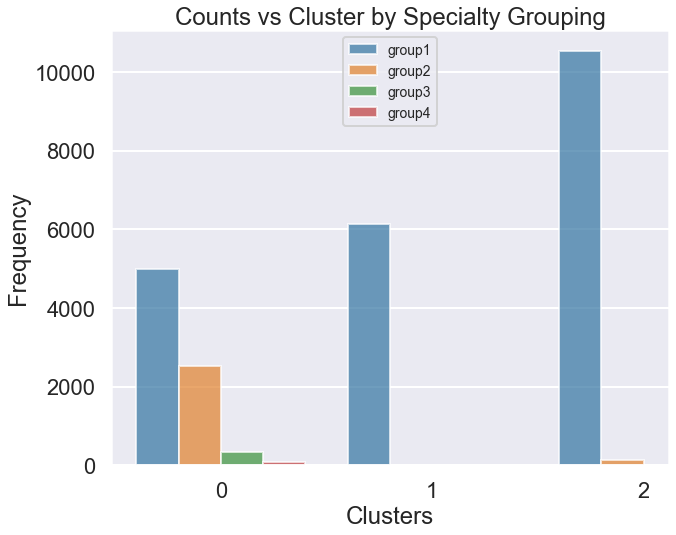

In [194]:
clust_group22 = df_main2.groupby(['Cluster_2', 'Spec_group']).Specialty.count().reset_index()

plt.figure(figsize=(10,8))
sns.barplot(x='Cluster_2', y='Specialty', data=clust_group22, hue='Spec_group', alpha=0.7)
plt.xlabel('Clusters')
plt.ylabel('Frequency')
plt.title('Counts vs Cluster by Specialty Grouping')
plt.legend(loc= 'upper center', prop={'size': 14})
plt.plot()

[]

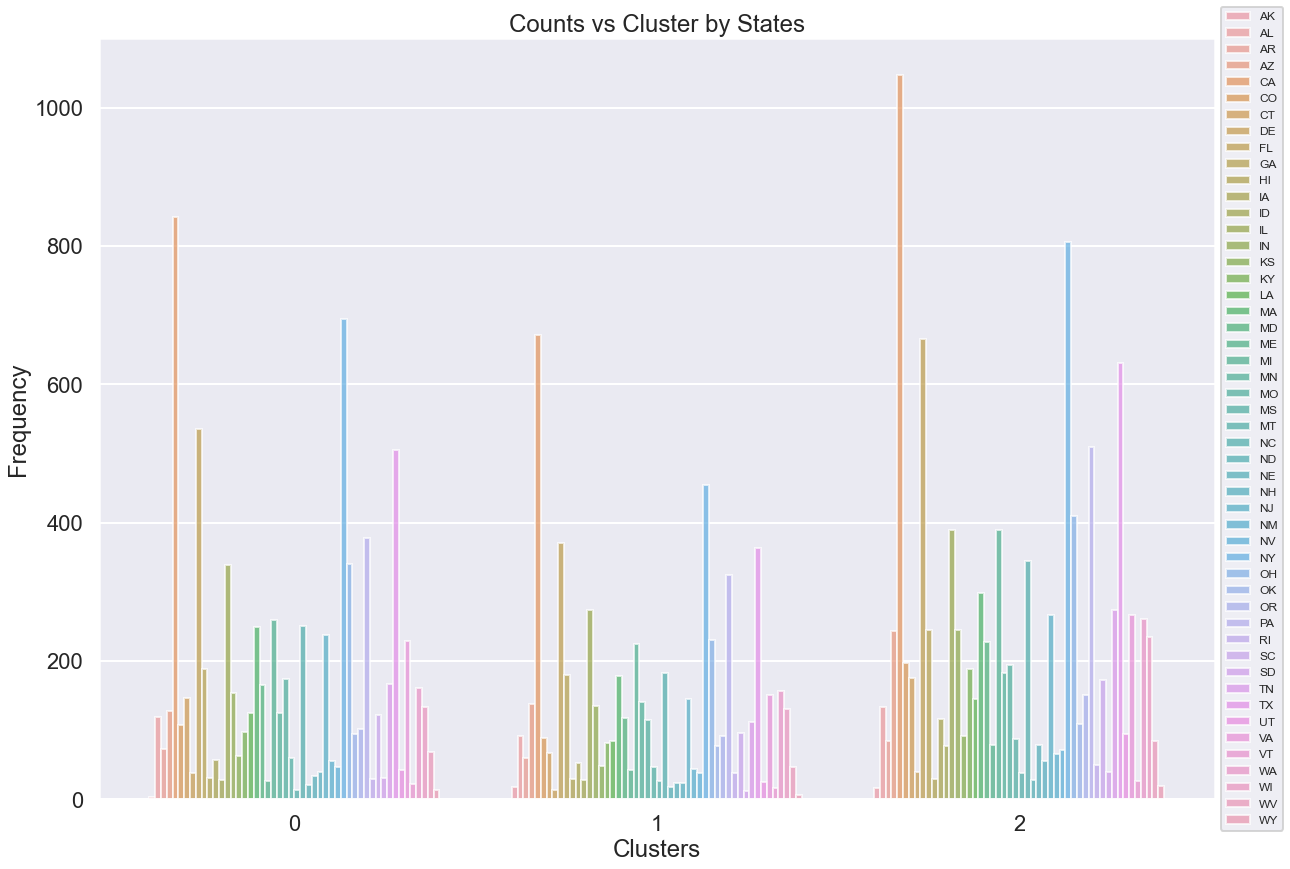

In [195]:
clust_group23 = df_main2.groupby(['Cluster_2', 'Abbrev']).Specialty.count().reset_index()

plt.figure(figsize=(20,14))
sns.barplot(x='Cluster_2', y='Specialty', data=clust_group23, hue='Abbrev', alpha=0.7)
plt.xlabel('Clusters')
plt.ylabel('Frequency')
plt.title('Counts vs Cluster by States')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 12})
plt.plot()

Each cluster seemed to have a have the same components leading the clusters. Group1 for Specialties is mostly made up of the specialsts who have higher opioid prescriptions given. In regards to the states, the states with the higher populations seem to be leading the way in the various clusters as well.

(0.0, 10.0)

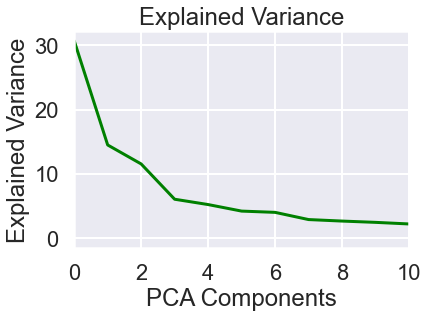

In [196]:
# Initialize a new PCA model with a default number of components.
pca2 = sklearn.decomposition.PCA()
pca2.fit(x_cols2)

# Do the rest on your own :)
plt.plot(pca2.explained_variance_, c='g', linewidth=3)
plt.title('Explained Variance')
plt.xlabel('PCA Components')
plt.ylabel('Explained Variance')
plt.xlim([0, 10])

The elbow curve looks to be at 1

### Other Clustering Algorithms

In [197]:
algorithms2 = ['AffinityPropagation2', 'SpectralClustering2', 'AgglomerativeClustering2', 'DBSCAN2']
algorithm_silscores2 = pd.Series(index=algorithms2)

C:\Users\Jimsyd\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


In [198]:
#Affinity Propagation (x_cols2)

#find the best value for damping parameter. 
dampings = [0.5, 0.6, 0.7, 0.8, 0.9]
best_score = 0.0
for damping in dampings:
    ap = AffinityPropagation(damping=damping)
    labels = ap.fit_predict(x_cols2)
    silhouette_avg = silhouette_score(x_cols2, labels, random_state=10)
    print("For damping =", damping,
          "The average silhouette_score is :", silhouette_avg)
    if silhouette_avg > best_score:
        best_score = silhouette_avg
        best_damping = damping
        
print('Best damping parameter:', best_damping)
algorithm_silscores2.loc['AffinityPropagation2'] = best_score

For damping = 0.5 The average silhouette_score is : 0.3639348336445824
For damping = 0.6 The average silhouette_score is : 0.36129127526579585
For damping = 0.7 The average silhouette_score is : 0.36129127526579585
For damping = 0.8 The average silhouette_score is : -9.779002225371128e-05
For damping = 0.9 The average silhouette_score is : -9.779002225371128e-05
Best damping parameter: 0.5


In [199]:
#Spectral Clustering (x_cols2)

#find the best value for n_clusters parameter. 
range_n_clusters = range(2,11)
best_score = 0.0
for n_clusters in range_n_clusters:
    sc = SpectralClustering(n_clusters=n_clusters)
    labels = sc.fit_predict(x_cols2)
    silhouette_avg = silhouette_score(x_cols2, labels, random_state=10)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    if silhouette_avg > best_score:
        best_score = silhouette_avg
        best_n_clusters = n_clusters
        
print('Best n_clusters parameter:',best_n_clusters)
algorithm_silscores2.loc['SpectralClustering2'] = best_score

C:\Users\Jimsyd\Anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


For n_clusters = 2 The average silhouette_score is : 0.5929097196557072


C:\Users\Jimsyd\Anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


For n_clusters = 3 The average silhouette_score is : 0.5713631763384777


C:\Users\Jimsyd\Anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
C:\Users\Jimsyd\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:296: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  ).fit(X, sample_weight=sample_weight)
C:\Users\Jimsyd\Anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


For n_clusters = 4 The average silhouette_score is : 0.5713631763384777


C:\Users\Jimsyd\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:296: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  ).fit(X, sample_weight=sample_weight)
C:\Users\Jimsyd\Anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


For n_clusters = 5 The average silhouette_score is : 0.5713631763384777


C:\Users\Jimsyd\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:296: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  ).fit(X, sample_weight=sample_weight)
C:\Users\Jimsyd\Anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


For n_clusters = 6 The average silhouette_score is : 0.5713631763384777


C:\Users\Jimsyd\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:296: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  ).fit(X, sample_weight=sample_weight)
C:\Users\Jimsyd\Anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


For n_clusters = 7 The average silhouette_score is : 0.5713631763384777


C:\Users\Jimsyd\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:296: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  ).fit(X, sample_weight=sample_weight)
C:\Users\Jimsyd\Anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


For n_clusters = 8 The average silhouette_score is : 0.5713631763384777


C:\Users\Jimsyd\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:296: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  ).fit(X, sample_weight=sample_weight)
C:\Users\Jimsyd\Anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


For n_clusters = 9 The average silhouette_score is : 0.5713631763384777
For n_clusters = 10 The average silhouette_score is : 0.5713631763384777
Best n_clusters parameter: 2


C:\Users\Jimsyd\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:296: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  ).fit(X, sample_weight=sample_weight)


In [200]:
#Agglomerative Clustering (x_cols2)

#find the best value for n_clusters parameter. 
range_n_clusters = range(2,11)
best_score = 0.0
for n_clusters in range_n_clusters:
    ac = AgglomerativeClustering(n_clusters=n_clusters)
    labels = ac.fit_predict(x_cols2)
    silhouette_avg = silhouette_score(x_cols2, labels, random_state=10)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    if silhouette_avg > best_score:
        best_score = silhouette_avg
        best_n_clusters = n_clusters
        
print('Best n_clusters parameter:',best_n_clusters)
algorithm_silscores2.loc['AgglomerativeClustering2'] = best_score

For n_clusters = 2 The average silhouette_score is : 0.750628348136885
For n_clusters = 3 The average silhouette_score is : 0.7488355496134914
For n_clusters = 4 The average silhouette_score is : 0.48022392116076246
For n_clusters = 5 The average silhouette_score is : 0.4721916922564833
For n_clusters = 6 The average silhouette_score is : 0.4692417392909587
For n_clusters = 7 The average silhouette_score is : 0.46170175401010066
For n_clusters = 8 The average silhouette_score is : 0.45678828309103714
For n_clusters = 9 The average silhouette_score is : 0.4417503388704778
For n_clusters = 10 The average silhouette_score is : 0.443612780026244
Best n_clusters parameter: 2


When applying agglomerative clustering, the results are pretty similar to spectral clustering but with a better silhouette score. Agglomerative clustering seems to be the best one to use.

In [201]:
#DBSCAN (x_cols2)

#find the best value for min_samples parameter. 
range_min_samples = [1, 2]
best_score = 0.0
for min_samples in range_min_samples:
    db = DBSCAN(min_samples=min_samples)
    labels = db.fit_predict(x_cols2)
    silhouette_avg = silhouette_score(x_cols2, labels, random_state=10)
    print("For min_samples =", min_samples,
          "The average silhouette_score is :", silhouette_avg)
    if silhouette_avg > best_score:
        best_score = silhouette_avg
        best_min_samples = min_samples
        
print('Best min_samples parameter:',best_min_samples)
algorithm_silscores2.loc['DBSCAN2'] = best_score

For min_samples = 1 The average silhouette_score is : 0.037037037037037035
For min_samples = 2 The average silhouette_score is : -0.41754558235017175
Best min_samples parameter: 1


In [202]:
print(algorithm_silscores2)

AffinityPropagation2        0.363935
SpectralClustering2         0.592910
AgglomerativeClustering2    0.750628
DBSCAN2                     0.037037
dtype: float64


The clustering algorithms offer different results with Agglomerative Clustering offering the highest silhouette score. None of the scores offer high enough scores though. More features would be needed to raise the scores higher.